# 1. Setup và kết nối Google Sheets

In [ ]:
# Cài đặt thư viện cần thiết
!pip install gspread plotly kaleido wordcloud seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Cấu hình matplotlib cho tiếng Việt
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('seaborn-v0_8')

# Cấu hình Plotly
import plotly.io as pio
pio.templates.default = "plotly_white"

print("✅ Đã cài đặt và import thành công tất cả thư viện!")

# Kết nối Google Drive và Sheets
from google.colab import auth, drive
import gspread
from google.auth import default

# Xác thực Google Drive
auth.authenticate_user()
drive.mount('/content/drive')

# Kết nối Google Sheets
creds, _ = default()
gc = gspread.authorize(creds)

print("✅ Đã kết nối thành công Google Drive và Sheets!")


# Load dữ liệu từ Google Sheets
# Thay thế URL này bằng URL Google Sheets của bạn
SHEET_URL = "https://docs.google.com/spreadsheets/d/15eMfEvqNvy1qBNG1NXwr7eSBsYZA6KqlBB3lTyzTfhM/edit?gid=2035877512"  # Bạn cần thay thế URL này

try:
    # Mở sheet theo URL
    sheet = gc.open_by_url(SHEET_URL)
    worksheet = sheet.worksheet("referral")

    # Đọc dữ liệu
    data = worksheet.get_all_records()
    df = pd.DataFrame(data)

    print(f"✅ Đã load thành công {len(df)} dòng dữ liệu từ Google Sheets!")
    print(f"📊 Số cột: {len(df.columns)}")

except:
    # Nếu không có kết nối Sheets, sử dụng dữ liệu mẫu
    print("⚠️ Không thể kết nối Sheets, sử dụng dữ liệu mẫu...")

    # Dữ liệu mẫu từ JSON bạn cung cấp
    sample_data = [
        {
            "ma nhan vien": "004380",
            "ma doi tac": "BS2032 - Nguyễn Văn Hải",
            "ten benh nhan": "HỒ QUỐC MINH",
            "chuyen khoa kham": "TH - Tiêu hóa",
            "ngay nhap vien": "1/2/2025",
            "ngay xuat vien": "1/11/2025",
            "ip op": "IP",
            "doanh thu": "84,367,417",
            "cong gioi thieu": "13,170,723",
            "thang  bao cao": "2025 01",
            "ngay hoa don": "1/11/2025",
            "benh vien": "HMSG",
            "team": "Referral",
            "ten nhan vien": "Mai Lê Bảo Trâm",
            "date": "1/2/2025",
            "nam": 2025,
            "thang": 1,
            "tuan": "W1",
            "ngay": 2,
            "ti le": "16%",
            "ten doi tac": "Nguyễn Văn Hải",
            "chuyen khoa doi tac": "bacsi",
            "hang muc": "Bác Sĩ",
            "noi cong tac": "",
            "ngay hop tac": "",
            "id chuyen khoa": "TH",
            "id doi tac": "BS2032",
            "ma benh nhan": "hồquốcminh",
            "Ngày nhập viện fix": "1/2/2025",
            "Ngày xuất viện fix": "1/11/2025",
            "Ngày In hóa đơn fix": "1/11/2025"
        }
        # Thêm các bản ghi khác...
    ]

    df = pd.DataFrame(sample_data)

# Hiển thị thông tin cơ bản
print("\\n📋 Thông tin cơ bản về dataset:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")


✅ Đã cài đặt và import thành công tất cả thư viện!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Đã kết nối thành công Google Drive và Sheets!
✅ Đã load thành công 3831 dòng dữ liệu từ Google Sheets!
📊 Số cột: 31
\n📋 Thông tin cơ bản về dataset:
Shape: (3831, 31)
Columns: ['ma nhan vien', 'ma doi tac', 'ten benh nhan', 'chuyen khoa kham', 'ngay nhap vien', 'ngay xuat vien', 'ip op', 'doanh thu', 'cong gioi thieu', 'thang  bao cao', 'ngay hoa don', 'benh vien', 'team', 'ten nhan vien', 'date', 'nam', 'thang', 'tuan', 'ngay', 'ti le', 'ten doi tac', 'chuyen khoa doi tac', 'hang muc', 'noi cong tac', 'ngay hop tac', 'id chuyen khoa', 'id doi tac', 'ma benh nhan', 'Ngày nhập viện fix', 'Ngày xuất viện fix', 'Ngày In hóa đơn fix']


# 🧹 2. Làm sạch và chuẩn bị dữ liệu

In [ ]:
# Hàm làm sạch dữ liệu
def clean_and_prepare_data(df):
    """Làm sạch và chuẩn bị dữ liệu cho phân tích"""

    # Copy dataframe
    df_clean = df.copy()

    # Làm sạch số liệu tài chính (loại bỏ dấu phẩy và chuyển về số)
    financial_cols = ['doanh thu', 'cong gioi thieu']
    for col in financial_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(str).str.replace(',', '').str.replace(' ', '')
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Làm sạch tỷ lệ (chuyển % thành số thập phân)
    if 'ti le' in df_clean.columns:
        df_clean['ti_le_numeric'] = df_clean['ti le'].astype(str).str.replace('%', '').replace('', np.nan).astype(float) / 100

    # Chuyển đổi ngày tháng
    date_cols = ['ngay nhap vien', 'ngay xuat vien', 'ngay hoa don', 'date',
                 'Ngày nhập viện fix', 'Ngày xuất viện fix', 'Ngày In hóa đơn fix']

    for col in date_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col], format='%m/%d/%Y', errors='coerce')

    # Tính số ngày nằm viện
    if 'ngay nhap vien' in df_clean.columns and 'ngay xuat vien' in df_clean.columns:
        df_clean['so_ngay_nam_vien'] = (df_clean['ngay xuat vien'] - df_clean['ngay nhap vien']).dt.days

    # Tính doanh thu trung bình mỗi ngày
    df_clean['doanh_thu_moi_ngay'] = df_clean['doanh thu'] / df_clean['so_ngay_nam_vien'].replace(0, 1)

    # Làm sạch tên
    text_cols = ['ten benh nhan', 'ten doi tac', 'ten nhan vien']
    for col in text_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(str).str.title()

    # Tạo các cột phân loại
    df_clean['chuyen_khoa_ngan'] = df_clean['id chuyen khoa'] if 'id chuyen khoa' in df_clean.columns else 'Unknown'
    df_clean['quy'] = 'Q' + ((df_clean['thang'] - 1) // 3 + 1).astype(str) if 'thang' in df_clean.columns else 'Q1'


    # Phân loại doanh thu
    if 'doanh thu' in df_clean.columns:
        df_clean['phan_loai_doanh_thu'] = pd.cut(df_clean['doanh thu'],
                                                bins=[0, 10_000_000, 50_000_000, 100_000_000, float('inf')],
                                                labels=['Thấp (<10M)', 'Trung bình (10-50M)', 'Cao (50-100M)', 'Rất cao (>100M)'])

    return df_clean

# Áp dụng làm sạch dữ liệu
df_clean = clean_and_prepare_data(df)

print("🧹 Đã làm sạch dữ liệu thành công!")
print(f"📊 Thống kê sau khi làm sạch:")
print(f"- Tổng số bệnh nhân: {len(df_clean)}")
print(f"- Tổng doanh thu: {df_clean['doanh thu'].sum():,.0f} VNĐ")
print(f"- Tổng công giới thiệu: {df_clean['cong gioi thieu'].sum():,.0f} VNĐ")
print(f"- Số đối tác: {df_clean['ten doi tac'].nunique()}")
print(f"- Số chuyên khoa: {df_clean['chuyen khoa kham'].nunique()}")

# Hiển thị mẫu dữ liệu
df_clean.head()

🧹 Đã làm sạch dữ liệu thành công!
📊 Thống kê sau khi làm sạch:
- Tổng số bệnh nhân: 3831
- Tổng doanh thu: 48,716,049,112 VNĐ
- Tổng công giới thiệu: 4,168,614,756 VNĐ
- Số đối tác: 121
- Số chuyên khoa: 26


,ma nhan vien,ma doi tac,ten benh nhan,chuyen khoa kham,ngay nhap vien,ngay xuat vien,ip op,doanh thu,cong gioi thieu,thang bao cao,...,ma benh nhan,Ngày nhập viện fix,Ngày xuất viện fix,Ngày In hóa đơn fix,ti_le_numeric,so_ngay_nam_vien,doanh_thu_moi_ngay,chuyen_khoa_ngan,quy,phan_loai_doanh_thu
0,4380,BS2032 - Nguyễn Văn Hải,Hồ Quốc Minh,TH - Tiêu hóa,2025-01-02,2025-01-11,IP,84367417.0,13170723.0,2025 01,...,hồquốcminh,2025-01-02,2025-01-11,2025-01-11,0.16,9.0,9.374157e+06,TH,Q1,Cao (50-100M)
1,4380,BS2019 - Cảnh Lâm,Nguyễn Hoàng Thùy Duyên,PS - Phụ sản,2025-01-04,2025-01-06,IP,14182400.0,4033122.0,2025 01,...,nguyễnhoàngthùyduyên,2025-01-04,2025-01-06,2025-01-06,0.28,2.0,7.091200e+06,PS,Q1,Trung bình (10-50M)
2,4380,BS2028 - Lê Quang Quốc Ánh,Đoàn Thị Kim Rạng,TH - Tiêu hóa,2024-12-31,2025-01-07,IP,66938445.0,6683203.0,2025 01,...,đoànthịkimrạng,2024-12-31,2025-01-07,2025-01-01,0.10,7.0,9.562635e+06,TH,Q1,Cao (50-100M)
3,4380,BS2019 - Cảnh Lâm,Đào Thị Thúy Vi,PS - Phụ sản,2025-01-01,2025-01-04,IP,21645178.0,4257005.0,2025 01,...,đàothịthúyvi,2025-01-01,2025-01-04,2025-01-04,0.20,3.0,7.215059e+06,PS,Q1,Trung bình (10-50M)
4,4380,BS2028 - Lê Quang Quốc Ánh,Trần Thanh Liêm,TH - Tiêu hóa,2025-01-02,2025-01-13,IP,74115384.0,1911792.0,2025 01,...,trầnthanhliêm,2025-01-02,2025-01-13,2025-01-13,0.03,11.0,6.737762e+06,TH,Q1,Cao (50-100M)


# 📊 3. Dashboard Tổng Quan



**📊 Export Charts to Specific Google Drive Folder - FIXED **

In [ ]:
# Xuất biểu đồ theo thứ tự vào thư mục Drive chỉ định

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import warnings
import os
from google.colab import drive, auth
import gspread
from google.auth import default
from datetime import datetime

warnings.filterwarnings('ignore')

# Mount Google Drive nếu chưa mount
try:
    drive.mount('/content/drive')
except:
    print("Drive đã được mount rồi")

# Authenticate for Google services
auth.authenticate_user()
creds, _ = default()

# Tạo thư mục mới với timestamp để tránh conflict
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
TARGET_FOLDER = f"/content/drive/MyDrive/HMSG_Charts_{timestamp}"

# Tạo thư mục mới
try:
    os.makedirs(TARGET_FOLDER, exist_ok=False)  # Không cho phép ghi đè
    print(f"✅ Đã tạo thư mục mới: {TARGET_FOLDER}")
except FileExistsError:
    # Nếu vẫn conflict, tạo thư mục với tên khác
    TARGET_FOLDER = f"/content/drive/MyDrive/HMSG_Charts_Final"
    os.makedirs(TARGET_FOLDER, exist_ok=True)
    print(f"✅ Đã tạo thư mục: {TARGET_FOLDER}")

print(f"📁 Thư mục đích: {TARGET_FOLDER}")

# HMSG Brand Colors
HMSG_COLORS = {
    'primary': '#1f77b4',      # Xanh chính
    'secondary': '#ff7f0e',    # Cam phụ
    'success': '#2ca02c',      # Xanh lá
    'danger': '#d62728',       # Đỏ
    'warning': '#ff9800',      # Vàng cam
    'info': '#17a2b8',         # Xanh info
    'purple': '#6f42c1',       # Tím
    'pink': '#e83e8c'          # Hồng
}

# Configure matplotlib for high quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.3

# Vietnamese formatting functions
def format_vnd(amount):
    """Format currency Vietnamese style"""
    if pd.isna(amount) or amount == 0:
        return "0 VNĐ"
    return f"{amount:,.0f}".replace(',', '.') + " VNĐ"

def format_number(number):
    """Format number Vietnamese style"""
    if pd.isna(number) or number == 0:
        return "0"
    return f"{number:,.0f}".replace(',', '.')

def format_short(amount):
    """Format short currency (M, B)"""
    if pd.isna(amount) or amount == 0:
        return "0"

    if amount >= 1e9:
        return f"{amount/1e9:.1f}B"
    elif amount >= 1e6:
        return f"{amount/1e6:.1f}M"
    elif amount >= 1e3:
        return f"{amount/1e3:.0f}K"
    else:
        return f"{amount:.0f}"

def save_chart_numbered(fig, chart_number, chart_name, width=16, height=10):
    """Save chart with numbered filename"""
    filename = f"{chart_number:02d}_{chart_name}"
    filepath = f"{TARGET_FOLDER}/{filename}.png"

    try:
        if hasattr(fig, 'write_image'):  # Plotly figure
            fig.write_image(filepath, width=width*100, height=height*100, scale=2)
        else:  # Matplotlib figure
            fig.set_size_inches(width, height)
            fig.savefig(filepath, dpi=300, bbox_inches='tight',
                       facecolor='white', edgecolor='none', pad_inches=0.3)

        print(f"✅ Đã lưu: {filename}.png")
        return filepath
    except Exception as e:
        print(f"❌ Lỗi lưu file {filename}: {e}")
        return None

# Create enhanced sample data
def create_enhanced_sample_data():
    """Tạo dữ liệu mẫu phong phú để test"""
    np.random.seed(42)

    specialties = ['TH', 'PS', 'NK', 'TM', 'XN', 'CLS', 'RHM', 'YHCT']
    specialty_names = {
        'TH': 'Tiêu hóa', 'PS': 'Phụ sản', 'NK': 'Nhi khoa', 'TM': 'Tim mạch',
        'XN': 'Xét nghiệm', 'CLS': 'Cận lâm sàng', 'RHM': 'Răng hàm mặt', 'YHCT': 'Y học cổ truyền'
    }

    partners = [
        'Nguyễn Văn Hải', 'Cảnh Lâm', 'Lê Quang Quốc Ánh', 'Phạm Cao Cường',
        'Đỗ Quang Huân', 'Trần Minh Trí', 'Lê Thanh Phong', 'Võ Thị Hồng',
        'Đặng Duy Phương', 'Sơn Thành Nhân', 'Lê Văn Khoa', 'Lê Tuấn Vũ',
        'Mai Thị Kim Oanh', 'Hoàng Văn Đức', 'Phan Thị Lan'
    ]

    data = []
    for i in range(300):  # Tăng lên 300 records
        # Tạo phân bố doanh thu realistic hơn
        if np.random.random() < 0.1:  # 10% cases có doanh thu rất cao
            revenue = np.random.lognormal(mean=12, sigma=0.5) * 1000
        elif np.random.random() < 0.3:  # 30% cases có doanh thu cao
            revenue = np.random.lognormal(mean=11, sigma=0.7) * 1000
        else:  # 60% cases có doanh thu bình thường
            revenue = np.random.lognormal(mean=10, sigma=0.9) * 1000

        # Commission rate phụ thuộc vào specialty
        specialty = np.random.choice(specialties)
        if specialty in ['TM', 'PS']:  # Tim mạch và phụ sản có commission cao hơn
            commission_rate = np.random.uniform(0.15, 0.35)
        elif specialty in ['TH', 'NK']:  # Tiêu hóa và nhi khoa trung bình
            commission_rate = np.random.uniform(0.12, 0.28)
        else:  # Các khoa khác
            commission_rate = np.random.uniform(0.08, 0.25)

        commission = revenue * commission_rate

        # Thời gian realistic
        month = np.random.randint(1, 7)  # Jan to Jun 2025
        day = np.random.randint(1, 29)

        # Length of stay phụ thuộc vào specialty
        if specialty in ['TM', 'PS']:  # Tim mạch và phụ sản nằm viện lâu hơn
            los = np.random.randint(3, 15)
        elif specialty in ['XN', 'CLS']:  # Xét nghiệm và CLS nhanh
            los = np.random.randint(1, 5)
        else:
            los = np.random.randint(2, 12)

        data.append({
            'doanh thu': int(revenue),
            'cong gioi thieu': int(commission),
            'ten doi tac': np.random.choice(partners),
            'chuyen_khoa_ngan': specialty,
            'chuyen khoa kham': f"{specialty} - {specialty_names[specialty]}",
            'ma benh nhan': f'BN{i+1:03d}',
            'ten benh nhan': f'Bệnh nhân {i+1:03d}',
            'so_ngay_nam_vien': los,
            'nam': 2025,
            'thang': month,
            'tuan': f'W{((day-1)//7)+1}',
            'ti_le_numeric': commission_rate,
            'ngay nhap vien': f"{month}/{day}/2025"
        })

    return pd.DataFrame(data)

# Load enhanced data
df_clean = create_enhanced_sample_data()

print(f"📊 Dữ liệu: {len(df_clean)} bản ghi")
print(f"💰 Tổng doanh thu: {format_vnd(df_clean['doanh thu'].sum())}")
print(f"🤝 Tổng hoa hồng: {format_vnd(df_clean['cong gioi thieu'].sum())}")
print(f"👥 Số đối tác: {df_clean['ten doi tac'].nunique()}")
print(f"🏥 Số chuyên khoa: {df_clean['chuyen_khoa_ngan'].nunique()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Đã tạo thư mục mới: /content/drive/MyDrive/HMSG_Charts_20250622_195843
📁 Thư mục đích: /content/drive/MyDrive/HMSG_Charts_20250622_195843
📊 Dữ liệu: 300 bản ghi
💰 Tổng doanh thu: 14.800.003.891 VNĐ
🤝 Tổng hoa hồng: 3.043.835.673 VNĐ
👥 Số đối tác: 15
🏥 Số chuyên khoa: 8


**📈 Chart 1: Xu hướng Doanh thu theo Tháng**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Đã lưu chart vào: /content/drive/MyDrive/Colab Notebooks/hmsg google colab referral/01_xu_huong_doanh_thu.png


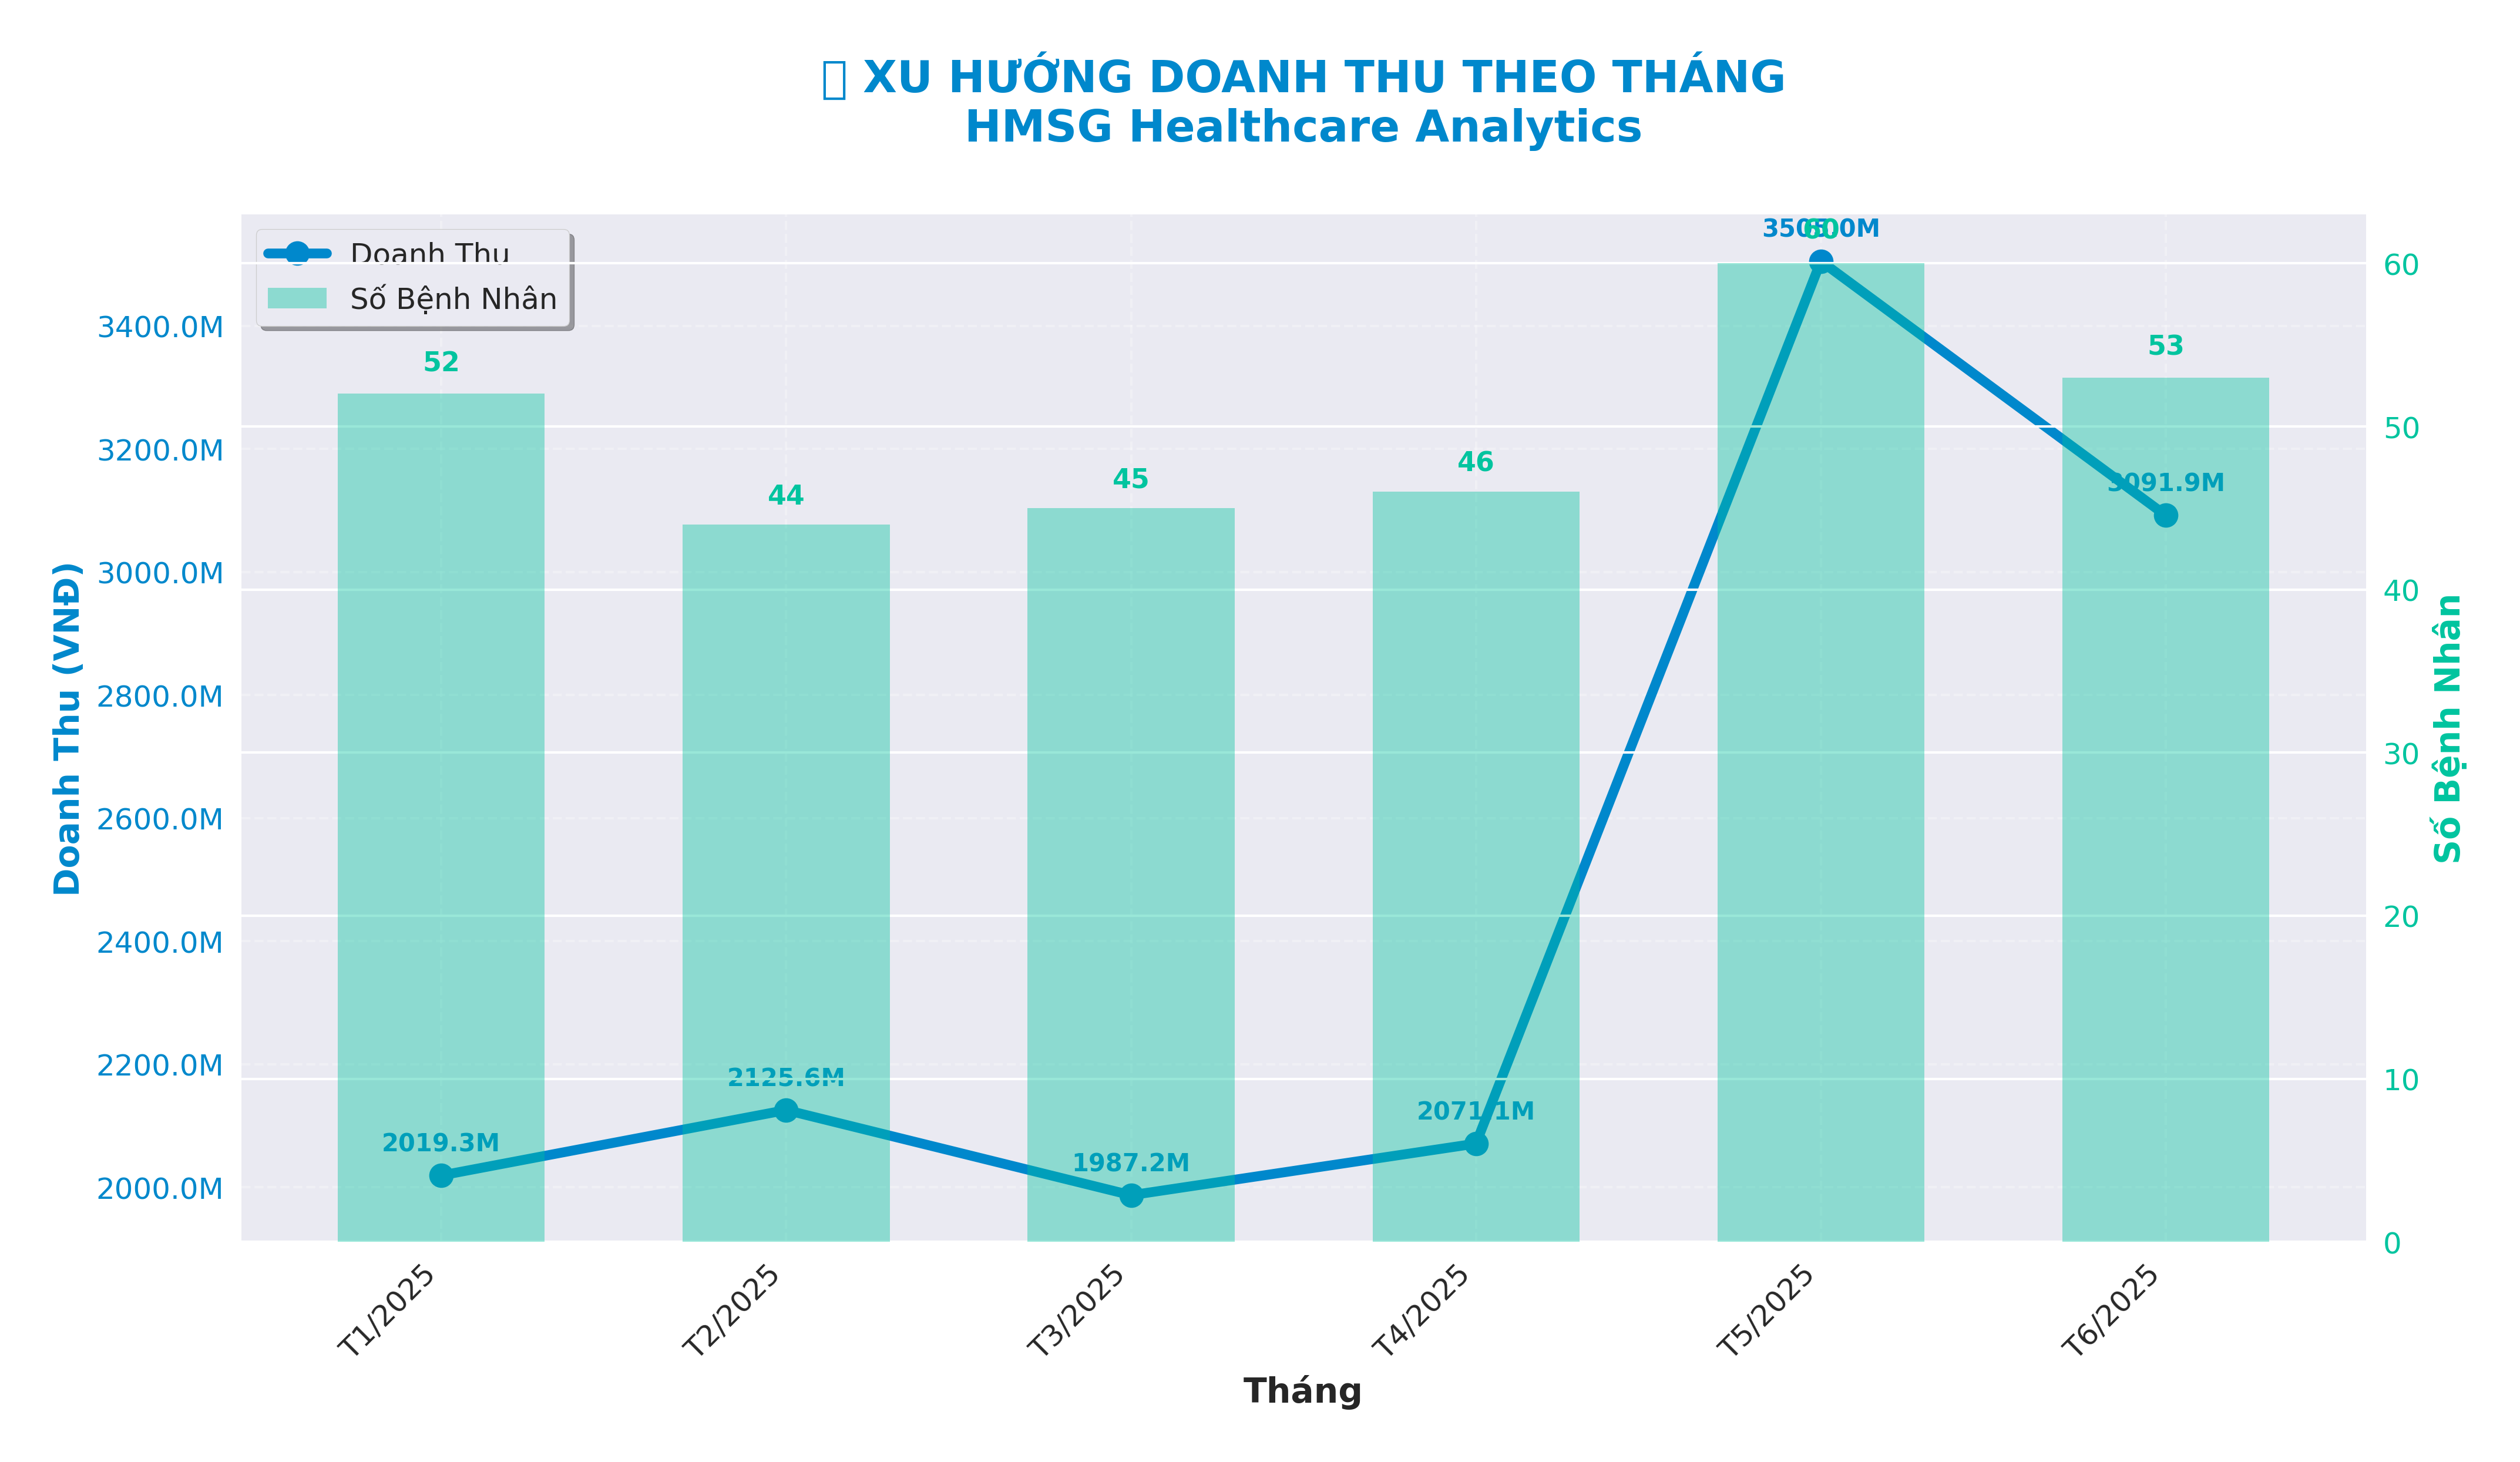

In [ ]:
# --- Mount Google Drive trước ---
from google.colab import drive
import os

drive.mount('/content/drive')

# Đảm bảo thư mục trên Drive đã tồn tại
output_dir = "/content/drive/MyDrive/Colab Notebooks/hmsg google colab referral"
os.makedirs(output_dir, exist_ok=True)

def format_short(x):
    # Định dạng số ngắn gọn (ví dụ: 1.2M, 800K)
    if x is None or pd.isna(x):
        return 'N/A'
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    else:
        return str(int(x))

def save_chart(fig, filename):
    """Lưu hình vào đúng thư mục trên Drive"""
    path = os.path.join(output_dir, f"{filename}.png")
    fig.savefig(path, bbox_inches='tight', dpi=200)
    print(f"✅ Đã lưu chart vào: {path}")
    return path

# Màu thương hiệu (ví dụ)
HMSG_COLORS = {
    'primary': '#0088CC',
    'success': '#00C49F',
    'danger': '#FF6347', # Added danger color
    'warning': '#FFD700', # Added warning color
    'info': '#ADD8E6'    # Added info color
}

def create_revenue_trend_chart(df):
    import matplotlib.pyplot as plt

    # Group by month
    monthly_data = df.groupby(['nam', 'thang']).agg({
        'doanh thu': 'sum',
        'cong gioi thieu': 'sum',
        'ma benh nhan': 'count'
    }).reset_index()

    monthly_data['thang_nam'] = 'T' + monthly_data['thang'].astype(str) + '/2025'

    # Create figure
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Revenue line
    color1 = HMSG_COLORS['primary']
    ax1.set_xlabel('Tháng', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Doanh Thu (VNĐ)', color=color1, fontsize=14, fontweight='bold')
    ax1.plot(monthly_data['thang_nam'], monthly_data['doanh thu'],
             color=color1, marker='o', linewidth=4, markersize=10, label='Doanh Thu')
    ax1.tick_params(axis='y', labelcolor=color1, labelsize=12)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_short(x)))

    # Second y-axis for patient count
    ax2 = ax1.twinx()
    color2 = HMSG_COLORS['success']
    ax2.set_ylabel('Số Bệnh Nhân', color=color2, fontsize=14, fontweight='bold')
    bars = ax2.bar(monthly_data['thang_nam'], monthly_data['ma benh nhan'],
                   alpha=0.4, color=color2, label='Số Bệnh Nhân', width=0.6)
    ax2.tick_params(axis='y', labelcolor=color2, labelsize=12)

    # Add value labels on bars
    for bar, value in zip(bars, monthly_data['ma benh nhan']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                 f'{int(value)}', ha='center', va='bottom',
                 fontsize=11, fontweight='bold', color=color2)

    # Add value labels on line
    for x, y in zip(monthly_data['thang_nam'], monthly_data['doanh thu']):
        ax1.annotate(format_short(y), (x, y), textcoords="offset points",
                     xytext=(0,10), ha='center', fontsize=10, fontweight='bold',
                     color=color1)

    # Title and styling
    plt.title('📈 XU HƯỚNG DOANH THU THEO THÁNG\nHMSG Healthcare Analytics',
              fontsize=18, fontweight='bold', color=color1, pad=30)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_axisbelow(True)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=12)

    # Legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left',
               fontsize=12, frameon=True, fancybox=True, shadow=True)

    plt.tight_layout()
    img_path = save_chart(fig, '01_xu_huong_doanh_thu')
    plt.show()
    return fig, img_path

# --- Sau đó gọi hàm vẽ biểu đồ ---
# revenue_trend_fig, img_path = create_revenue_trend_chart(df_clean)

# Generate chart
revenue_trend_fig = create_revenue_trend_chart(df_clean)

**👥 Chart 2: Top Đối tác theo Doanh thu**

✅ Đã lưu chart vào: /content/drive/MyDrive/Colab Notebooks/hmsg google colab referral/02_top_doi_tac.png


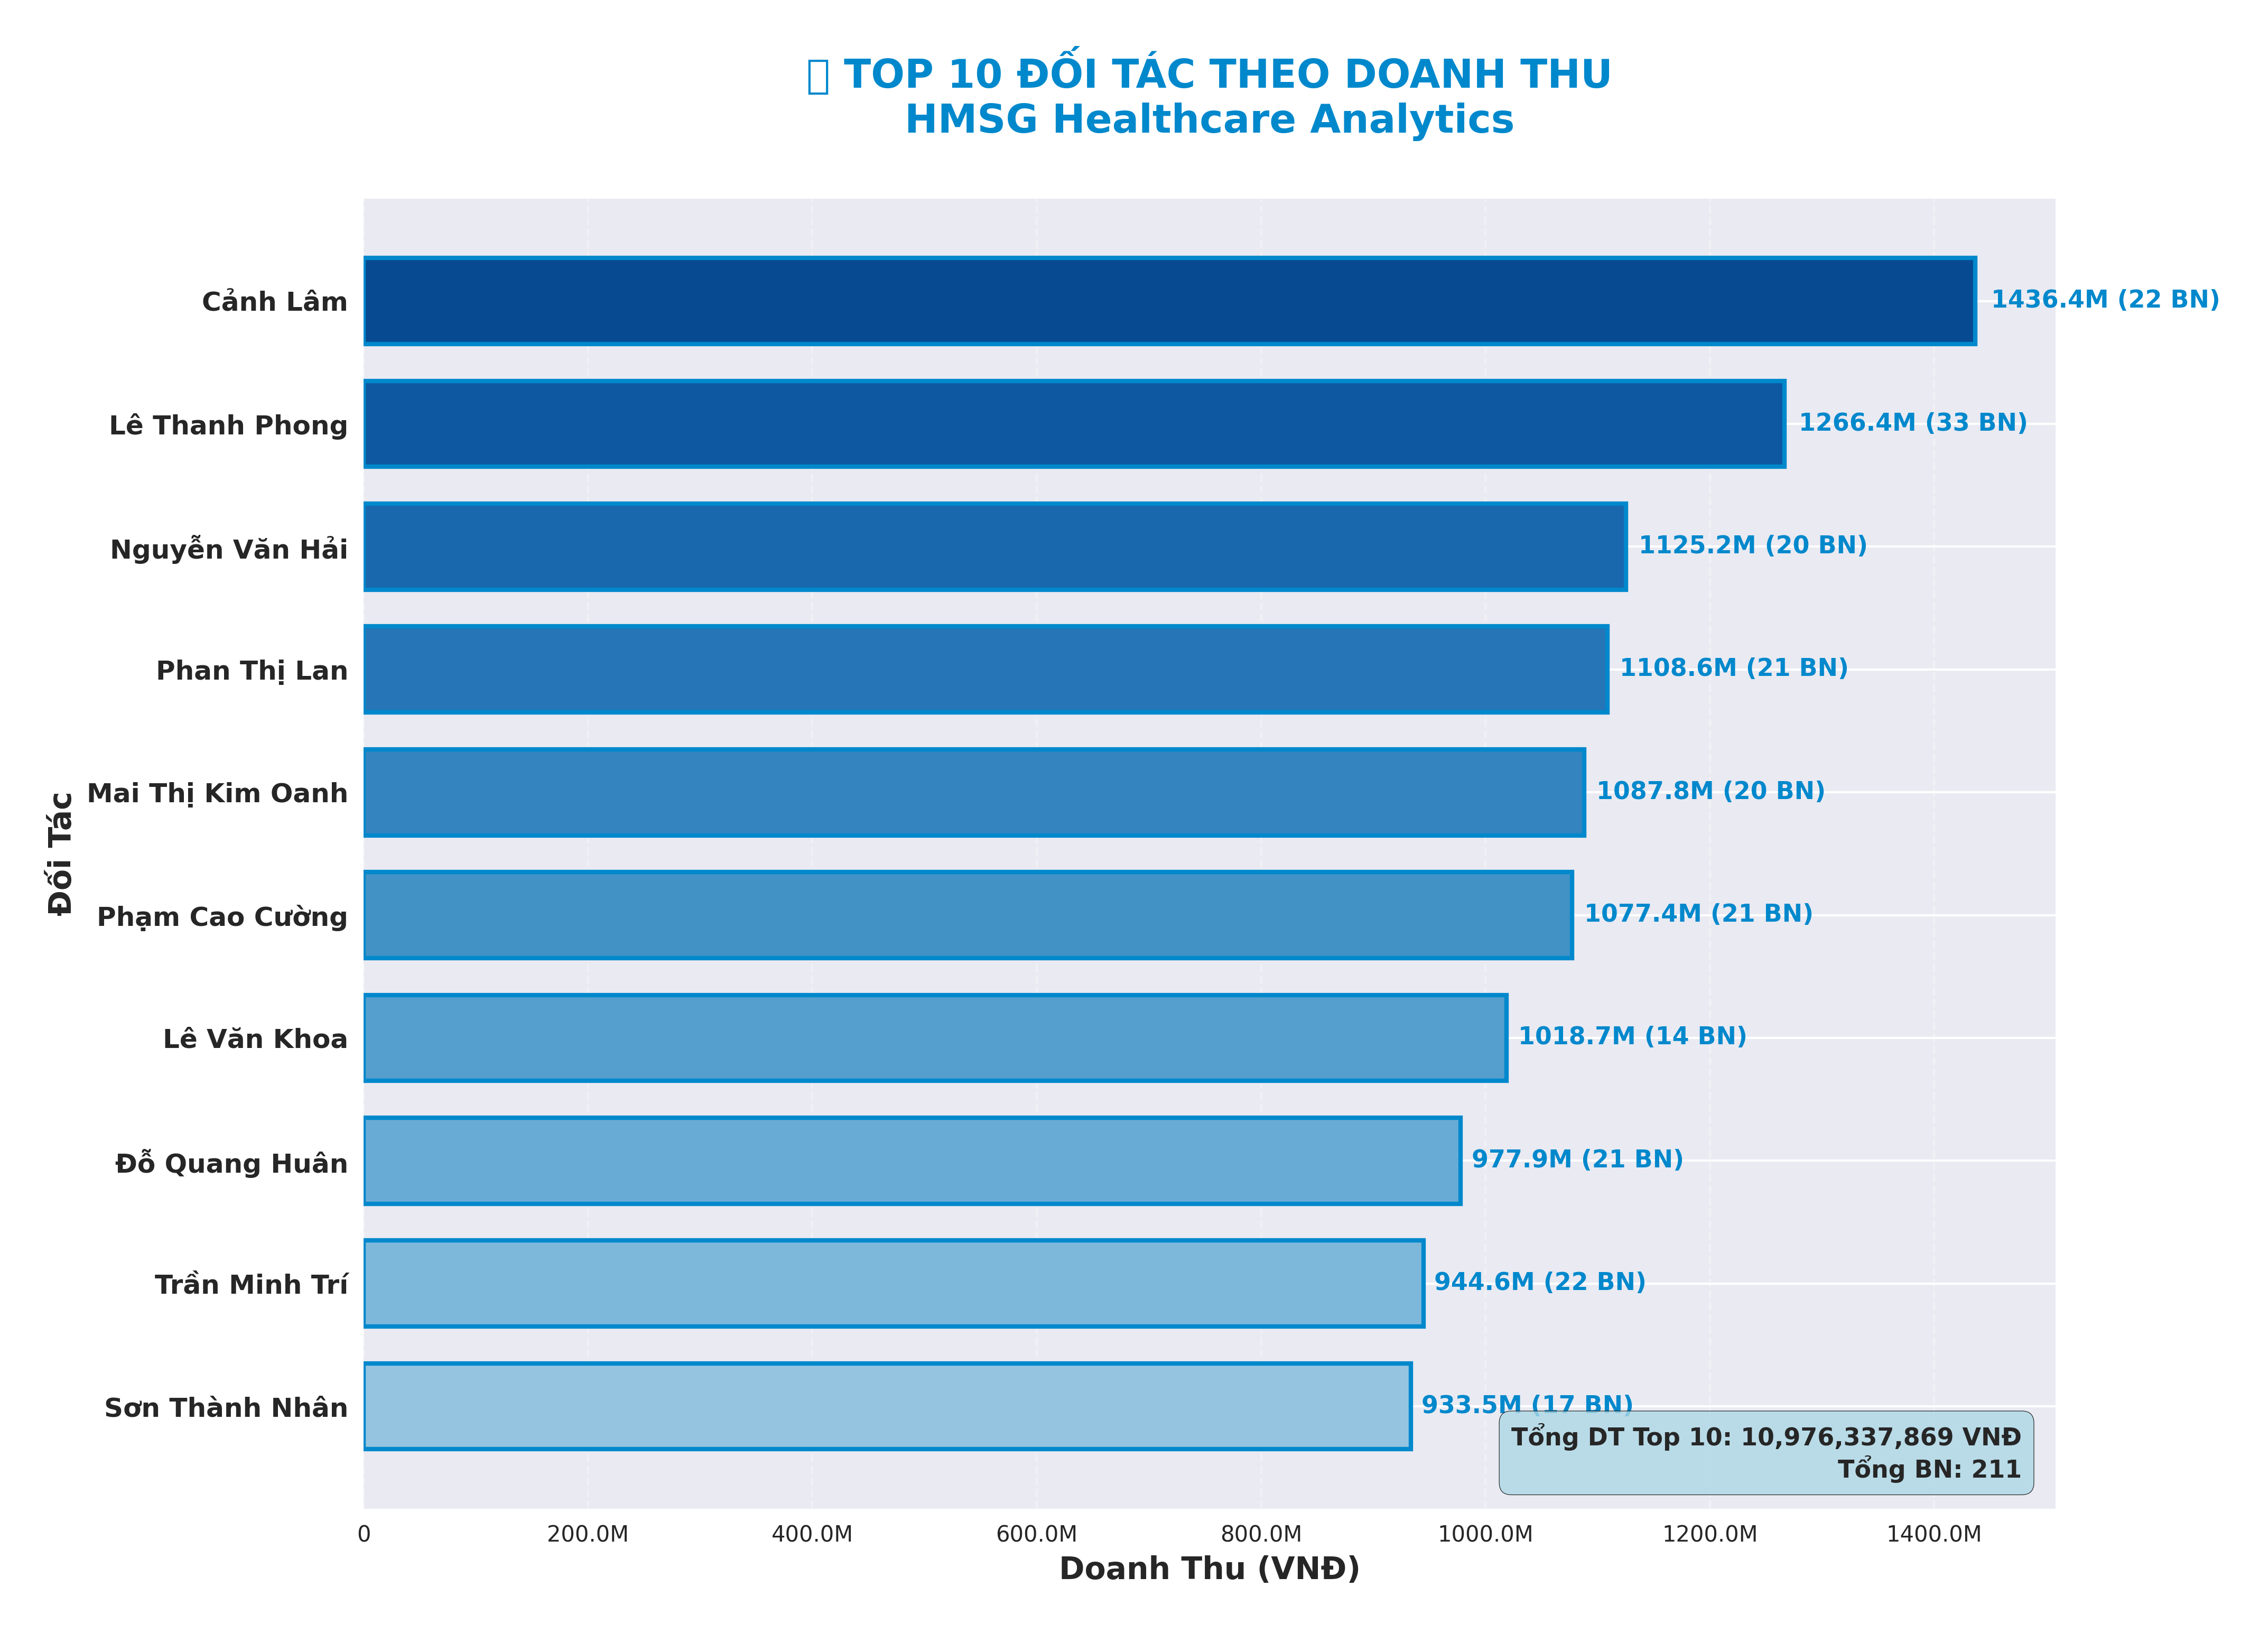

In [ ]:
# 👥 Chart 2: Top Đối tác theo Doanh thu

# Use functions defined in the first chart cell
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# output_dir = "/content/drive/MyDrive/Colab Notebooks/hmsg google colab referral"
# os.makedirs(output_dir, exist_ok=True)
# def format_short(x):
#     # Định dạng số ngắn gọn (ví dụ: 1.2M, 800K)
#     if x >= 1e6:
#         return f'{x/1e6:.1f}M'
#     elif x >= 1e3:
#         return f'{x/1e3:.0f}K'
#     else:
#         return str(int(x))
# def save_chart(fig, filename):
#     """Lưu hình vào đúng thư mục trên Drive"""
#     path = os.path.join(output_dir, f"{filename}.png")
#     fig.savefig(path, bbox_inches='tight', dpi=200)
#     print(f"✅ Đã lưu chart vào: {path}")
#     return path
# HMSG_COLORS = {
#     'primary': '#0088CC',
#     'success': '#00C49F',
# }


def create_top_partners_chart(df, top_n=10):
    # Group by partner
    partner_data = df.groupby('ten doi tac').agg({
        'doanh thu': 'sum',
        'ma benh nhan': 'count'
    }).reset_index()

    # Get top partners
    top_partners = partner_data.nlargest(top_n, 'doanh thu').sort_values('doanh thu', ascending=True)

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))

    # Create horizontal bars with gradient
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_partners)))
    bars = ax.barh(range(len(top_partners)), top_partners['doanh thu'],
                   color=colors, edgecolor=HMSG_COLORS['primary'], linewidth=2, height=0.7)

    # Add value labels
    for i, (bar, value, patients) in enumerate(zip(bars, top_partners['doanh thu'], top_partners['ma benh nhan'])):
        width = bar.get_width()
        ax.text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                f'{format_short(value)} ({patients} BN)', ha='left', va='center',
                fontsize=11, fontweight='bold', color=HMSG_COLORS['primary'])

    # Customize axes
    ax.set_yticks(range(len(top_partners)))
    ax.set_yticklabels(top_partners['ten doi tac'], fontsize=12, fontweight='bold')
    ax.set_xlabel('Doanh Thu (VNĐ)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Đối Tác', fontsize=14, fontweight='bold')

    # Format x-axis
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_short(x)))

    # Title
    plt.title(f'👥 TOP {top_n} ĐỐI TÁC THEO DOANH THU\nHMSG Healthcare Analytics',
              fontsize=18, fontweight='bold', color=HMSG_COLORS['primary'], pad=30)

    # Grid and styling
    ax.grid(True, axis='x', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Summary box
    total_revenue = top_partners['doanh thu'].sum()
    total_patients = top_partners['ma benh nhan'].sum()
    def format_vnd(x):
        return f'{x:,.0f} VNĐ'
    def format_number(x):
        return f'{x:,.0f}'
    summary_text = f'Tổng DT Top {top_n}: {format_vnd(total_revenue)}\nTổng BN: {format_number(total_patients)}'

    ax.text(0.98, 0.02, summary_text, transform=ax.transAxes,
            bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.8),
            verticalalignment='bottom', horizontalalignment='right',
            fontsize=11, fontweight='bold')

    plt.tight_layout()
    save_chart(fig, '02_top_doi_tac')
    plt.show()

    return fig

# Generate chart
top_partners_fig = create_top_partners_chart(df_clean)

**🏥 Chart 3: Phân bố theo Chuyên khoa**

✅ Đã lưu chart vào: /content/drive/MyDrive/Colab Notebooks/hmsg google colab referral/03_phan_bo_chuyen_khoa.png


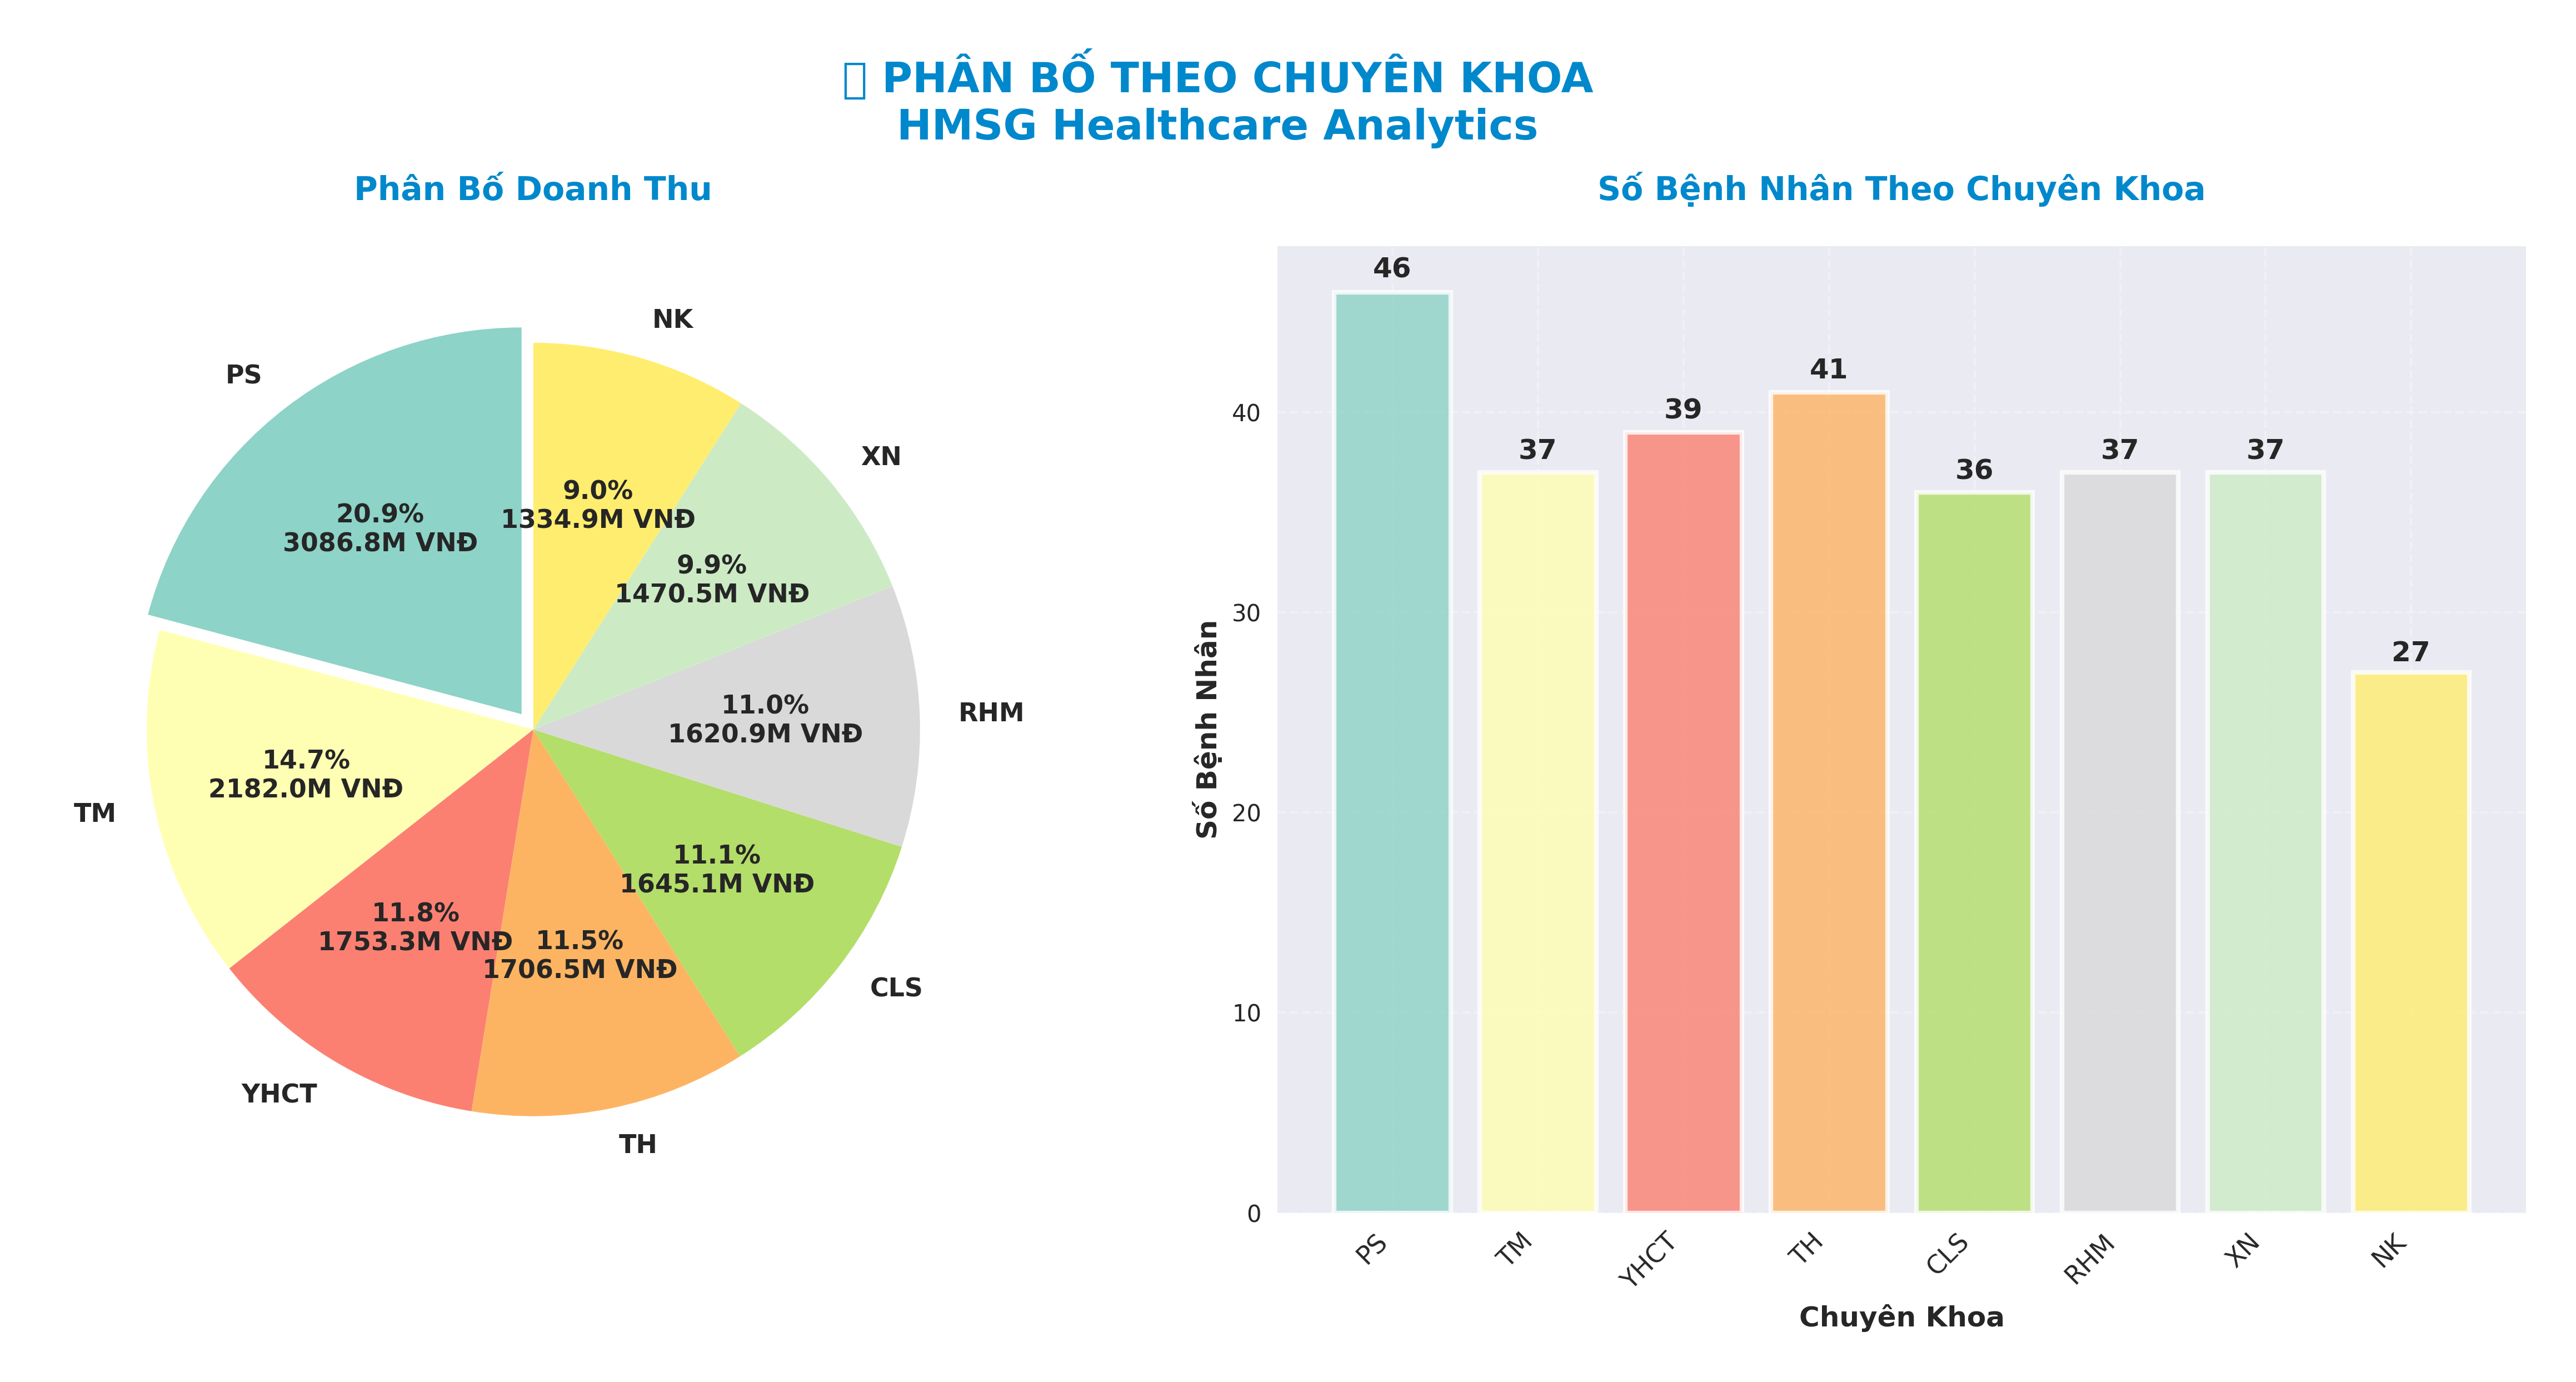

In [ ]:
# 🏥 Chart 3: Phân bố theo Chuyên khoa

# Use functions defined in the first chart cell
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# output_dir = "/content/drive/MyDrive/Colab Notebooks/hmsg google colab referral"
# os.makedirs(output_dir, exist_ok=True)
# def format_short(x):
#     # Định dạng số ngắn gọn (ví dụ: 1.2M, 800K)
#     if x >= 1e6:
#         return f'{x/1e6:.1f}M'
#     elif x >= 1e3:
#         return f'{x/1e3:.0f}K'
#     else:
#         return str(int(x))
# def save_chart(fig, filename):
#     """Lưu hình vào đúng thư mục trên Drive"""
#     path = os.path.join(output_dir, f"{filename}.png")
#     fig.savefig(path, bbox_inches='tight', dpi=200)
#     print(f"✅ Đã lưu chart vào: {path}")
#     return path
# HMSG_COLORS = {
#     'primary': '#0088CC',
#     'success': '#00C49F',
# }



def create_specialty_distribution_chart(df):
    # Group by specialty
    specialty_data = df.groupby('chuyen_khoa_ngan').agg({
        'doanh thu': 'sum',
        'ma benh nhan': 'count'
    }).reset_index()

    specialty_data = specialty_data.sort_values('doanh thu', ascending=False)

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Pie chart for revenue
    colors = plt.cm.Set3(np.linspace(0, 1, len(specialty_data)))

    def autopct_format(pct):
        total_revenue = specialty_data["doanh thu"].sum()
        # Handle potential division by zero or NaN
        if total_revenue == 0 or pd.isna(total_revenue):
             return f'{pct:.1f}%\nN/A VNĐ'
        return f'{pct:.1f}%\n{format_short(pct/100*total_revenue)} VNĐ'


    wedges, texts, autotexts = ax1.pie(specialty_data['doanh thu'],
                                      labels=specialty_data['chuyen_khoa_ngan'],
                                      colors=colors,
                                      autopct=autopct_format,
                                      startangle=90,
                                      textprops={'fontsize': 11, 'fontweight': 'bold'},
                                      explode=[0.05 if i == 0 else 0 for i in range(len(specialty_data))])

    ax1.set_title('Phân Bố Doanh Thu', fontsize=14, fontweight='bold',
                  color=HMSG_COLORS['primary'], pad=20)

    # Bar chart for patient count
    bars = ax2.bar(specialty_data['chuyen_khoa_ngan'], specialty_data['ma benh nhan'],
                   color=colors, edgecolor='white', linewidth=2, alpha=0.8)

    # Add value labels on bars
    for bar, value in zip(bars, specialty_data['ma benh nhan']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(value)}', ha='center', va='bottom',
                fontsize=12, fontweight='bold')

    ax2.set_title('Số Bệnh Nhân Theo Chuyên Khoa', fontsize=14, fontweight='bold',
                  color=HMSG_COLORS['primary'], pad=20)
    ax2.set_xlabel('Chuyên Khoa', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Số Bệnh Nhân', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_axisbelow(True)

    # Rotate x-axis labels
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=11)

    # Main title
    fig.suptitle('🏥 PHÂN BỐ THEO CHUYÊN KHOA\nHMSG Healthcare Analytics',
                fontsize=18, fontweight='bold', color=HMSG_COLORS['primary'], y=0.98)

    plt.tight_layout()
    save_chart(fig, '03_phan_bo_chuyen_khoa')
    plt.show()

    return fig

# Generate chart
specialty_fig = create_specialty_distribution_chart(df_clean)

**📅 Chart 4: Số Bệnh nhân theo Tuần**

✅ Đã lưu chart vào: /content/drive/MyDrive/Colab Notebooks/hmsg google colab referral/04_benh_nhan_theo_tuan.png


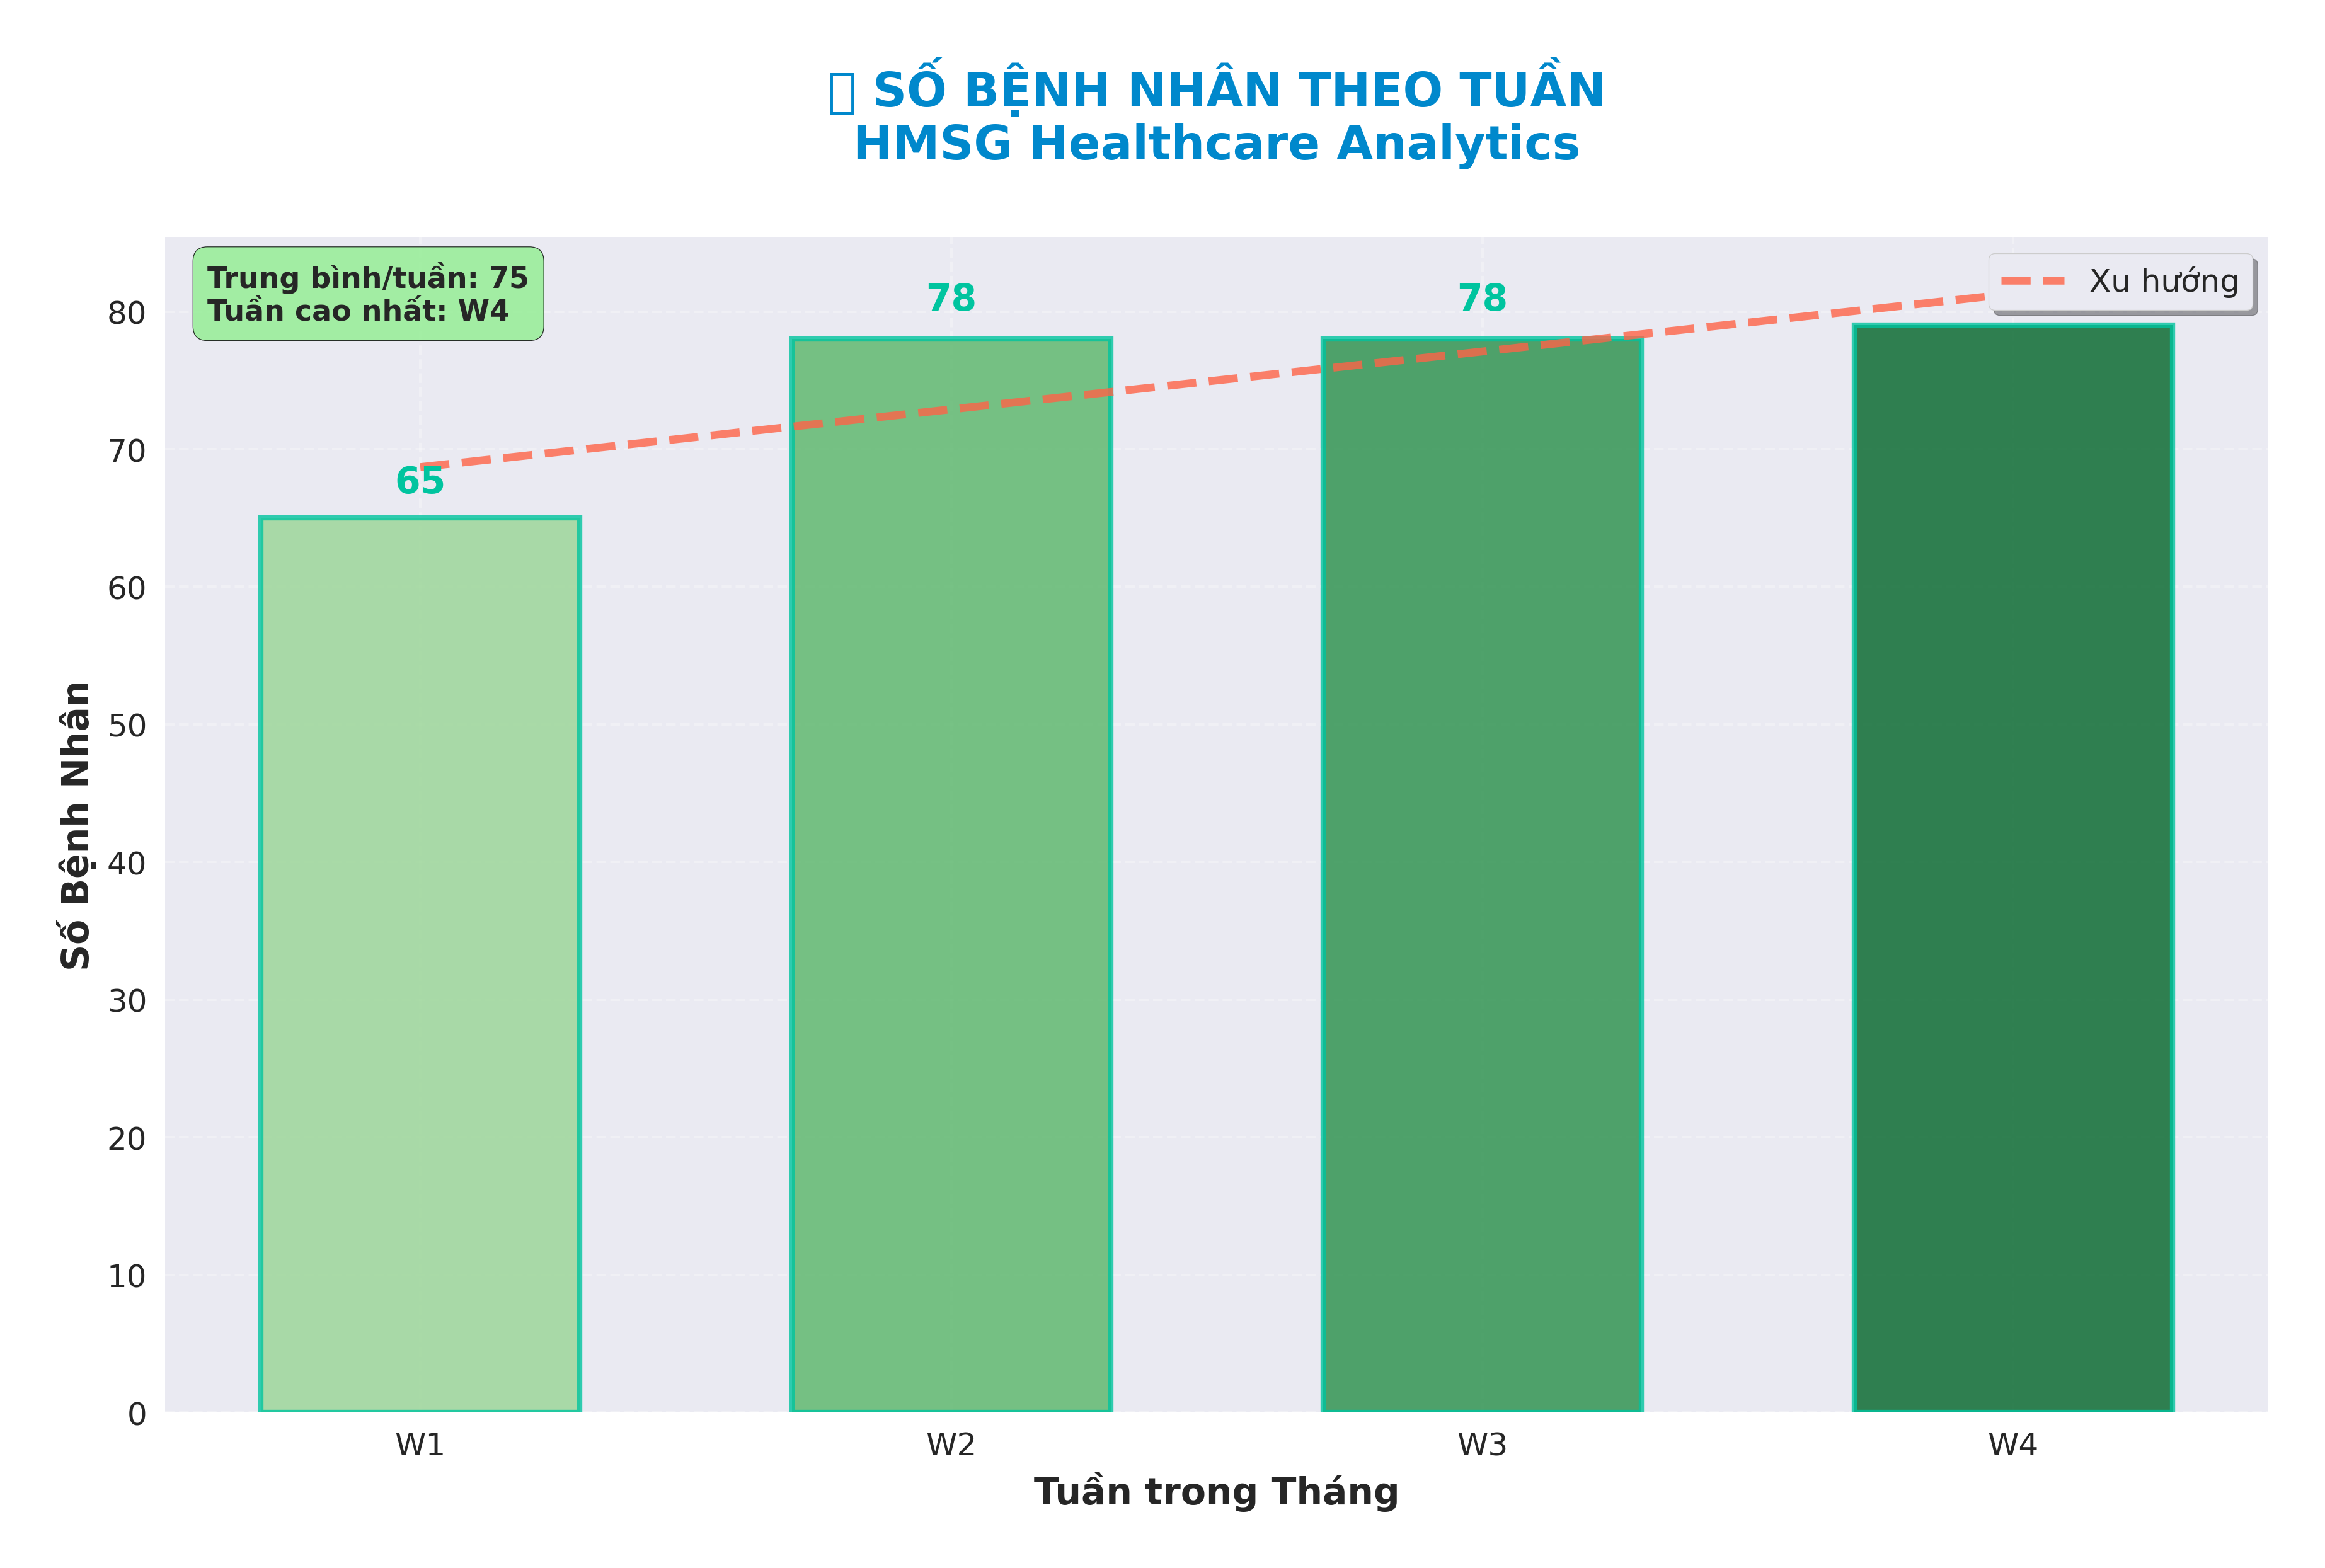

In [ ]:
# 📅 Chart 4: Số Bệnh nhân theo Tuần

# Use functions defined in the first chart cell
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# output_dir = "/content/drive/MyDrive/Colab Notebooks/hmsg google colab referral"
# os.makedirs(output_dir, exist_ok=True)
# def format_short(x):
#     # Định dạng số ngắn gọn (ví dụ: 1.2M, 800K)
#     if x >= 1e6:
#         return f'{x/1e6:.1f}M'
#     elif x >= 1e3:
#         return f'{x/1e3:.0f}K'
#     else:
#         return str(int(x))
# def save_chart(fig, filename):
#     """Lưu hình vào đúng thư mục trên Drive"""
#     path = os.path.join(output_dir, f"{filename}.png")
#     fig.savefig(path, bbox_inches='tight', dpi=200)
#     print(f"✅ Đã lưu chart vào: {path}")
#     return path
# Màu thương hiệu (ví dụ)
# HMSG_COLORS = {
#     'primary': '#0088CC',
#     'success': '#00C49F',
# }



def create_weekly_patients_chart(df):
    # Group by week
    weekly_data = df.groupby('tuan').agg({
        'ma benh nhan': 'count'
    }).reset_index()

    # Sort by week
    week_order = ['W1', 'W2', 'W3', 'W4', 'W5']
    weekly_data['week_num'] = weekly_data['tuan'].map({w: i for i, w in enumerate(week_order)})
    weekly_data = weekly_data.sort_values('week_num').fillna(0)

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create gradient bars
    colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(weekly_data)))
    bars = ax.bar(weekly_data['tuan'], weekly_data['ma benh nhan'],
                  color=colors, edgecolor=HMSG_COLORS['success'],
                  linewidth=2, alpha=0.8, width=0.6)

    # Add value labels on bars
    for bar, value in zip(bars, weekly_data['ma benh nhan']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                f'{int(value)}', ha='center', va='bottom',
                fontsize=14, fontweight='bold', color=HMSG_COLORS['success'])

    # Add trend line
    x_pos = range(len(weekly_data))
    if len(weekly_data) > 1:
        z = np.polyfit(x_pos, weekly_data['ma benh nhan'], 1)
        p = np.poly1d(z)
        ax.plot(x_pos, p(x_pos), "--", color=HMSG_COLORS['danger'],
                linewidth=3, alpha=0.8, label=f'Xu hướng')

    # Customize chart
    ax.set_xlabel('Tuần trong Tháng', fontsize=14, fontweight='bold')
    ax.set_ylabel('Số Bệnh Nhân', fontsize=14, fontweight='bold')
    ax.set_title('📅 SỐ BỆNH NHÂN THEO TUẦN\nHMSG Healthcare Analytics',
                fontsize=18, fontweight='bold', color=HMSG_COLORS['primary'], pad=30)

    # Grid and styling
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Increase tick size
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Legend if trend line exists
    if len(weekly_data) > 1:
        ax.legend(loc='upper right', fontsize=12, frameon=True, fancybox=True, shadow=True)

    # Statistics box
    avg_patients = weekly_data['ma benh nhan'].mean()
    max_week = weekly_data.loc[weekly_data['ma benh nhan'].idxmax(), 'tuan']

    def format_number(x):
        return f'{x:,.0f}'
    stats_text = f'Trung bình/tuần: {avg_patients:.0f}\nTuần cao nhất: {max_week}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgreen', alpha=0.8),
            verticalalignment='top', horizontalalignment='left',
            fontsize=11, fontweight='bold')

    plt.tight_layout()
    save_chart(fig, '04_benh_nhan_theo_tuan')
    plt.show()

    return fig

# Generate chart
weekly_fig = create_weekly_patients_chart(df_clean)

**💰 Chart 5: Phân bố Doanh thu (Histogram)**

✅ Đã lưu chart vào: /content/drive/MyDrive/Colab Notebooks/hmsg google colab referral/05_phan_bo_doanh_thu.png


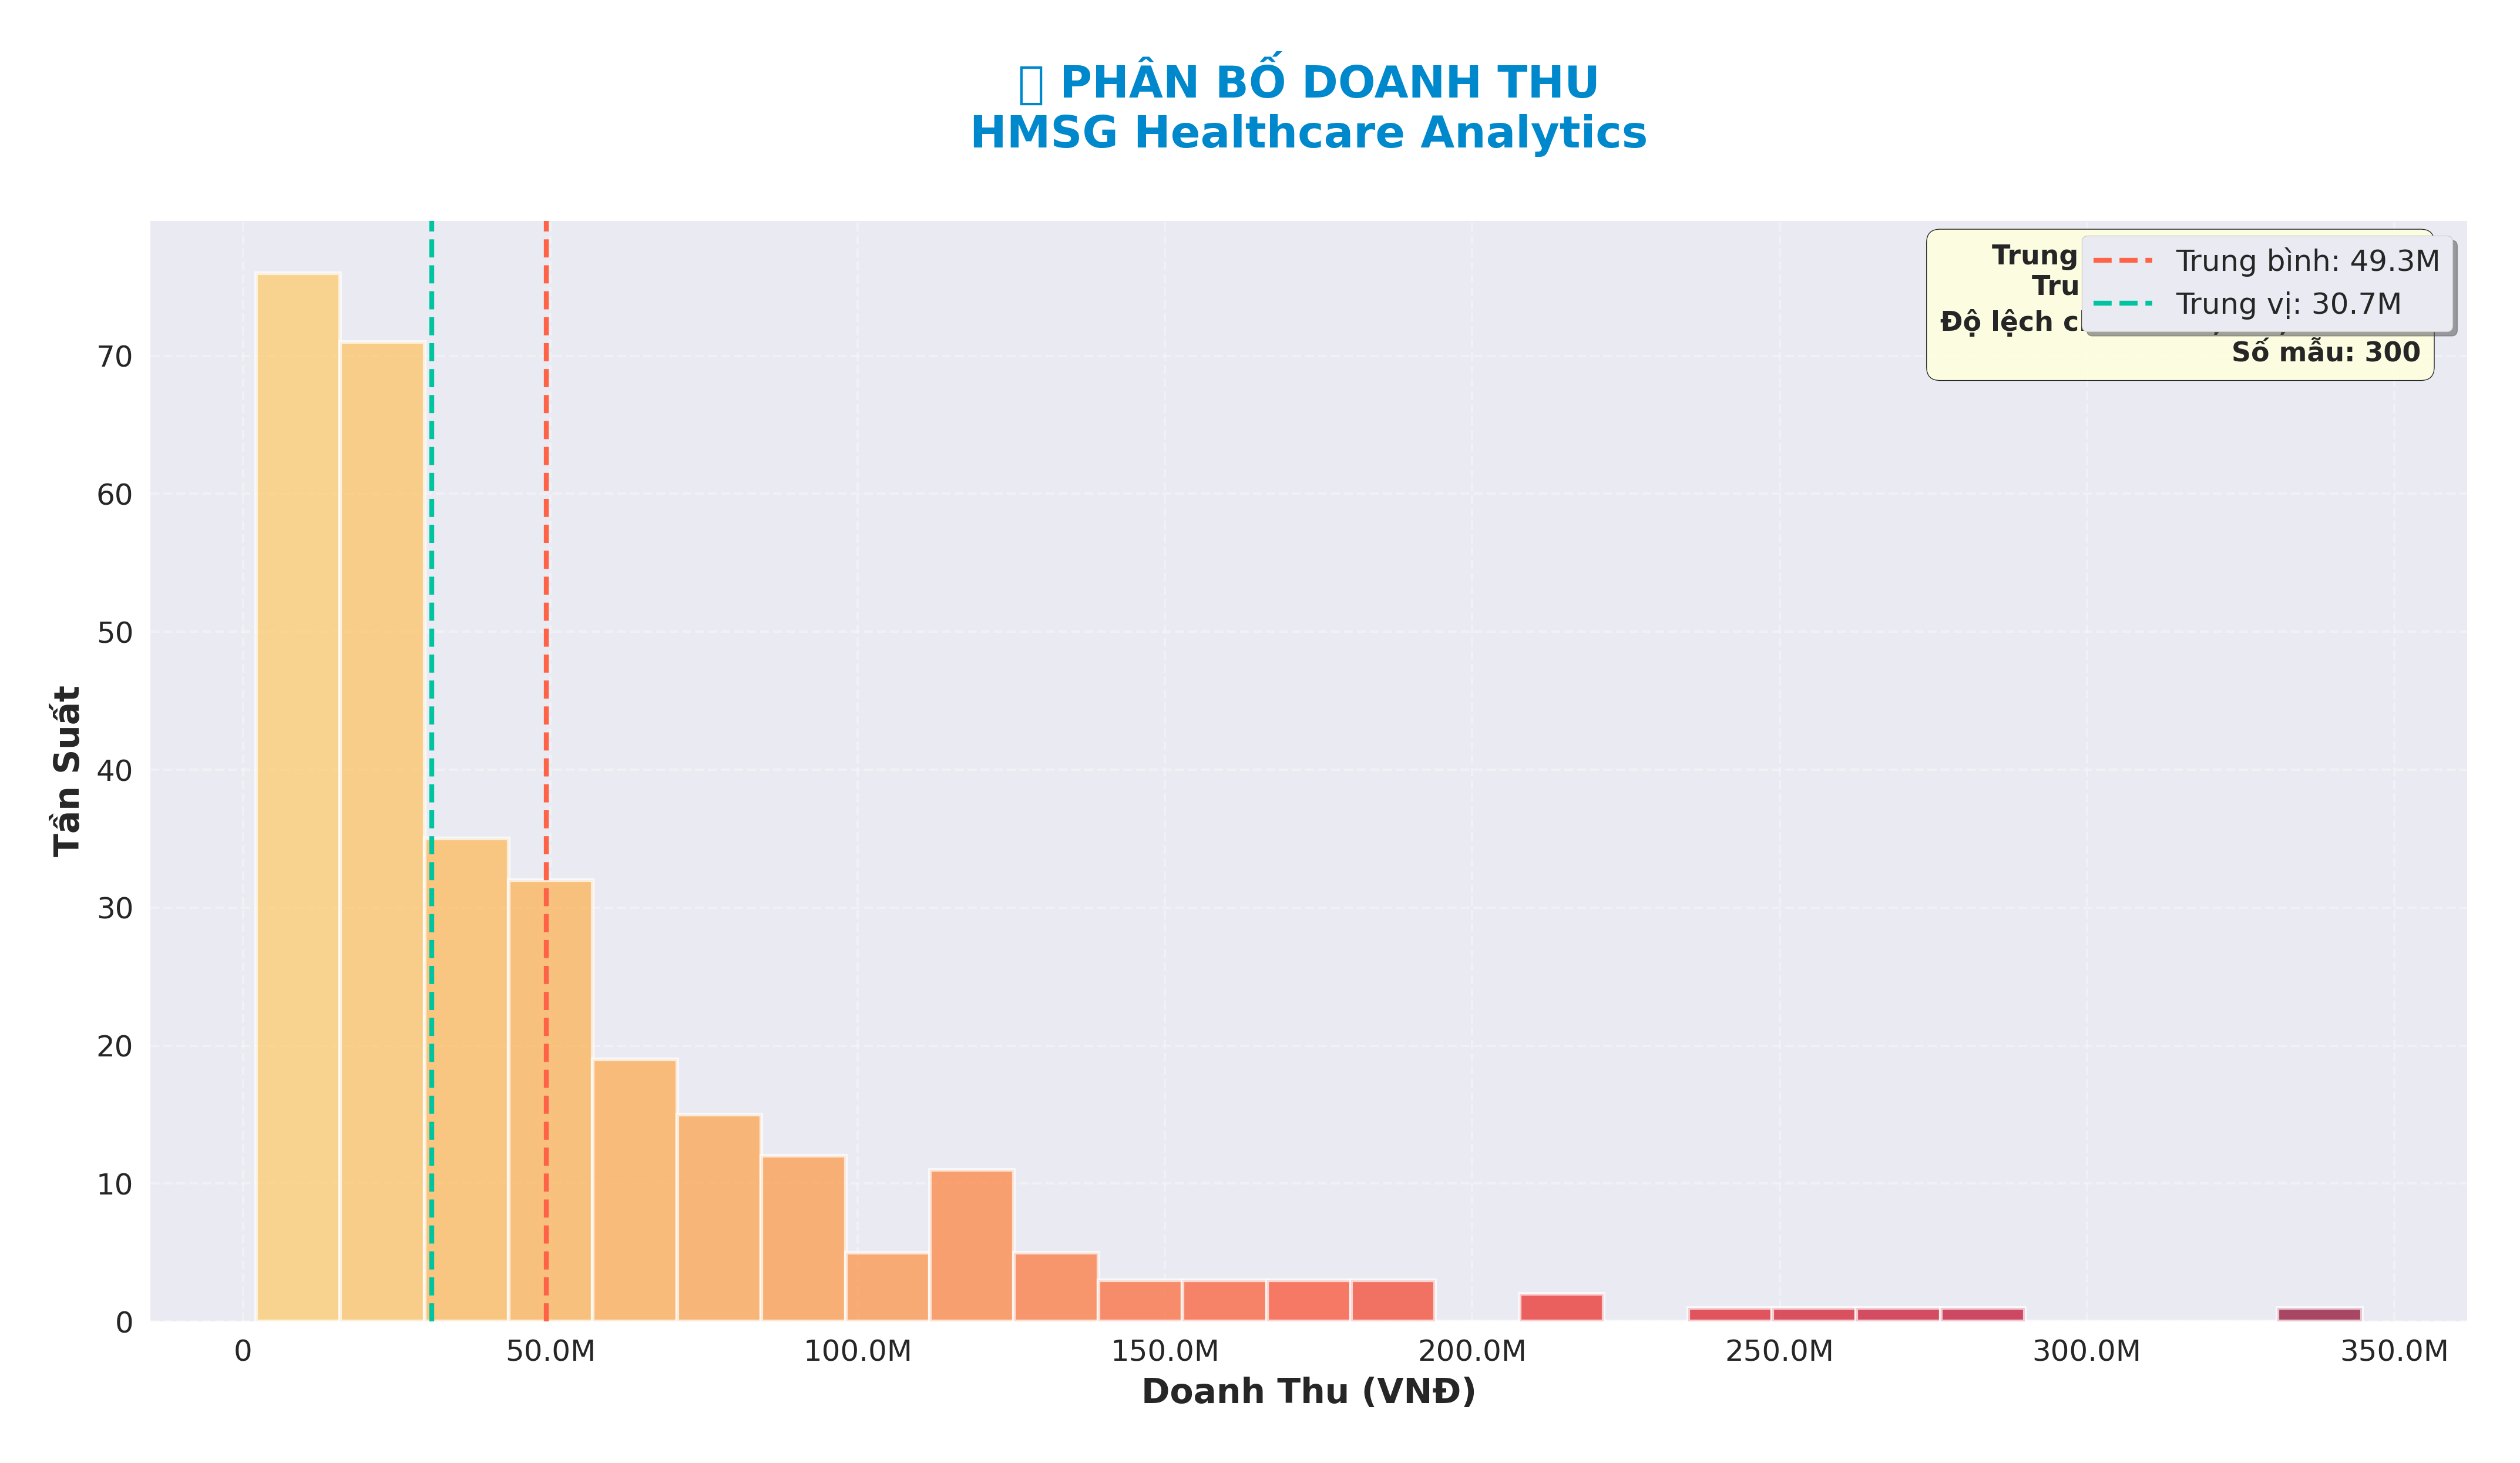

In [ ]:
# 💰 Chart 5: Phân bố Doanh thu (Histogram)

# Use functions defined in the first chart cell
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# output_dir = "/content/drive/MyDrive/Colab Notebooks/hmsg google colab referral"
# os.makedirs(output_dir, exist_ok=True)
# def format_short(x):
#     # Định dạng số ngắn gọn (ví dụ: 1.2M, 800K)
#     if x >= 1e6:
#         return f'{x/1e6:.1f}M'
#     elif x >= 1e3:
#         return f'{x/1e3:.0f}K'
#     else:
#         return str(int(x))
# def save_chart(fig, filename):
#     """Lưu hình vào đúng thư mục trên Drive"""
#     path = os.path.join(output_dir, f"{filename}.png")
#     fig.savefig(path, bbox_inches='tight', dpi=200)
#     print(f"✅ Đã lưu chart vào: {path}")
#     return path
# Màu thương hiệu (ví dụ)
# HMSG_COLORS = {
#     'primary': '#0088CC',
#     'success': '#00C49F',
# }



def create_revenue_histogram_chart(df):
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))

    # Create histogram with beautiful styling
    n, bins, patches = ax.hist(df['doanh thu'], bins=25,
                              color=HMSG_COLORS['warning'], alpha=0.7,
                              edgecolor='white', linewidth=1.5)

    # Color gradient for histogram bars
    for i, patch in enumerate(patches):
        patch.set_facecolor(plt.cm.YlOrRd(0.3 + 0.7 * i / len(patches)))

    # Customize chart
    ax.set_xlabel('Doanh Thu (VNĐ)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Tần Suất', fontsize=14, fontweight='bold')
    ax.set_title('💰 PHÂN BỐ DOANH THU\nHMSG Healthcare Analytics',
                fontsize=18, fontweight='bold', color=HMSG_COLORS['primary'], pad=30)

    # Format x-axis
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_short(x)))

    # Grid and styling
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Increase tick size
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Add statistics
    mean_revenue = df['doanh thu'].mean()
    median_revenue = df['doanh thu'].median()
    std_revenue = df['doanh thu'].std()

    # Add vertical lines for mean and median
    ax.axvline(mean_revenue, color=HMSG_COLORS['danger'], linestyle='--',
               linewidth=2, label=f'Trung bình: {format_short(mean_revenue)}')
    ax.axvline(median_revenue, color=HMSG_COLORS['success'], linestyle='--',
               linewidth=2, label=f'Trung vị: {format_short(median_revenue)}')

    # Statistics box
    def format_vnd(x):
        return f'{x:,.0f} VNĐ'
    def format_number(x):
        return f'{x:,.0f}'
    stats_text = f'Trung bình: {format_vnd(mean_revenue)}\nTrung vị: {format_vnd(median_revenue)}\nĐộ lệch chuẩn: {format_vnd(std_revenue)}\nSố mẫu: {format_number(len(df))}'

    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes,
            bbox=dict(boxstyle="round,pad=0.5", facecolor='lightyellow', alpha=0.9),
            verticalalignment='top', horizontalalignment='right',
            fontsize=11, fontweight='bold')

    # Legend
    ax.legend(loc='upper right', fontsize=12, frameon=True, fancybox=True, shadow=True)

    plt.tight_layout()
    save_chart(fig, '05_phan_bo_doanh_thu')
    plt.show()

    return fig

# Generate chart
histogram_fig = create_revenue_histogram_chart(df_clean)

**⏱️ Chart 6: Số ngày nằm viện**

✅ Đã lưu chart vào: /content/drive/MyDrive/Colab Notebooks/hmsg google colab referral/06_ngay_nam_vien.png


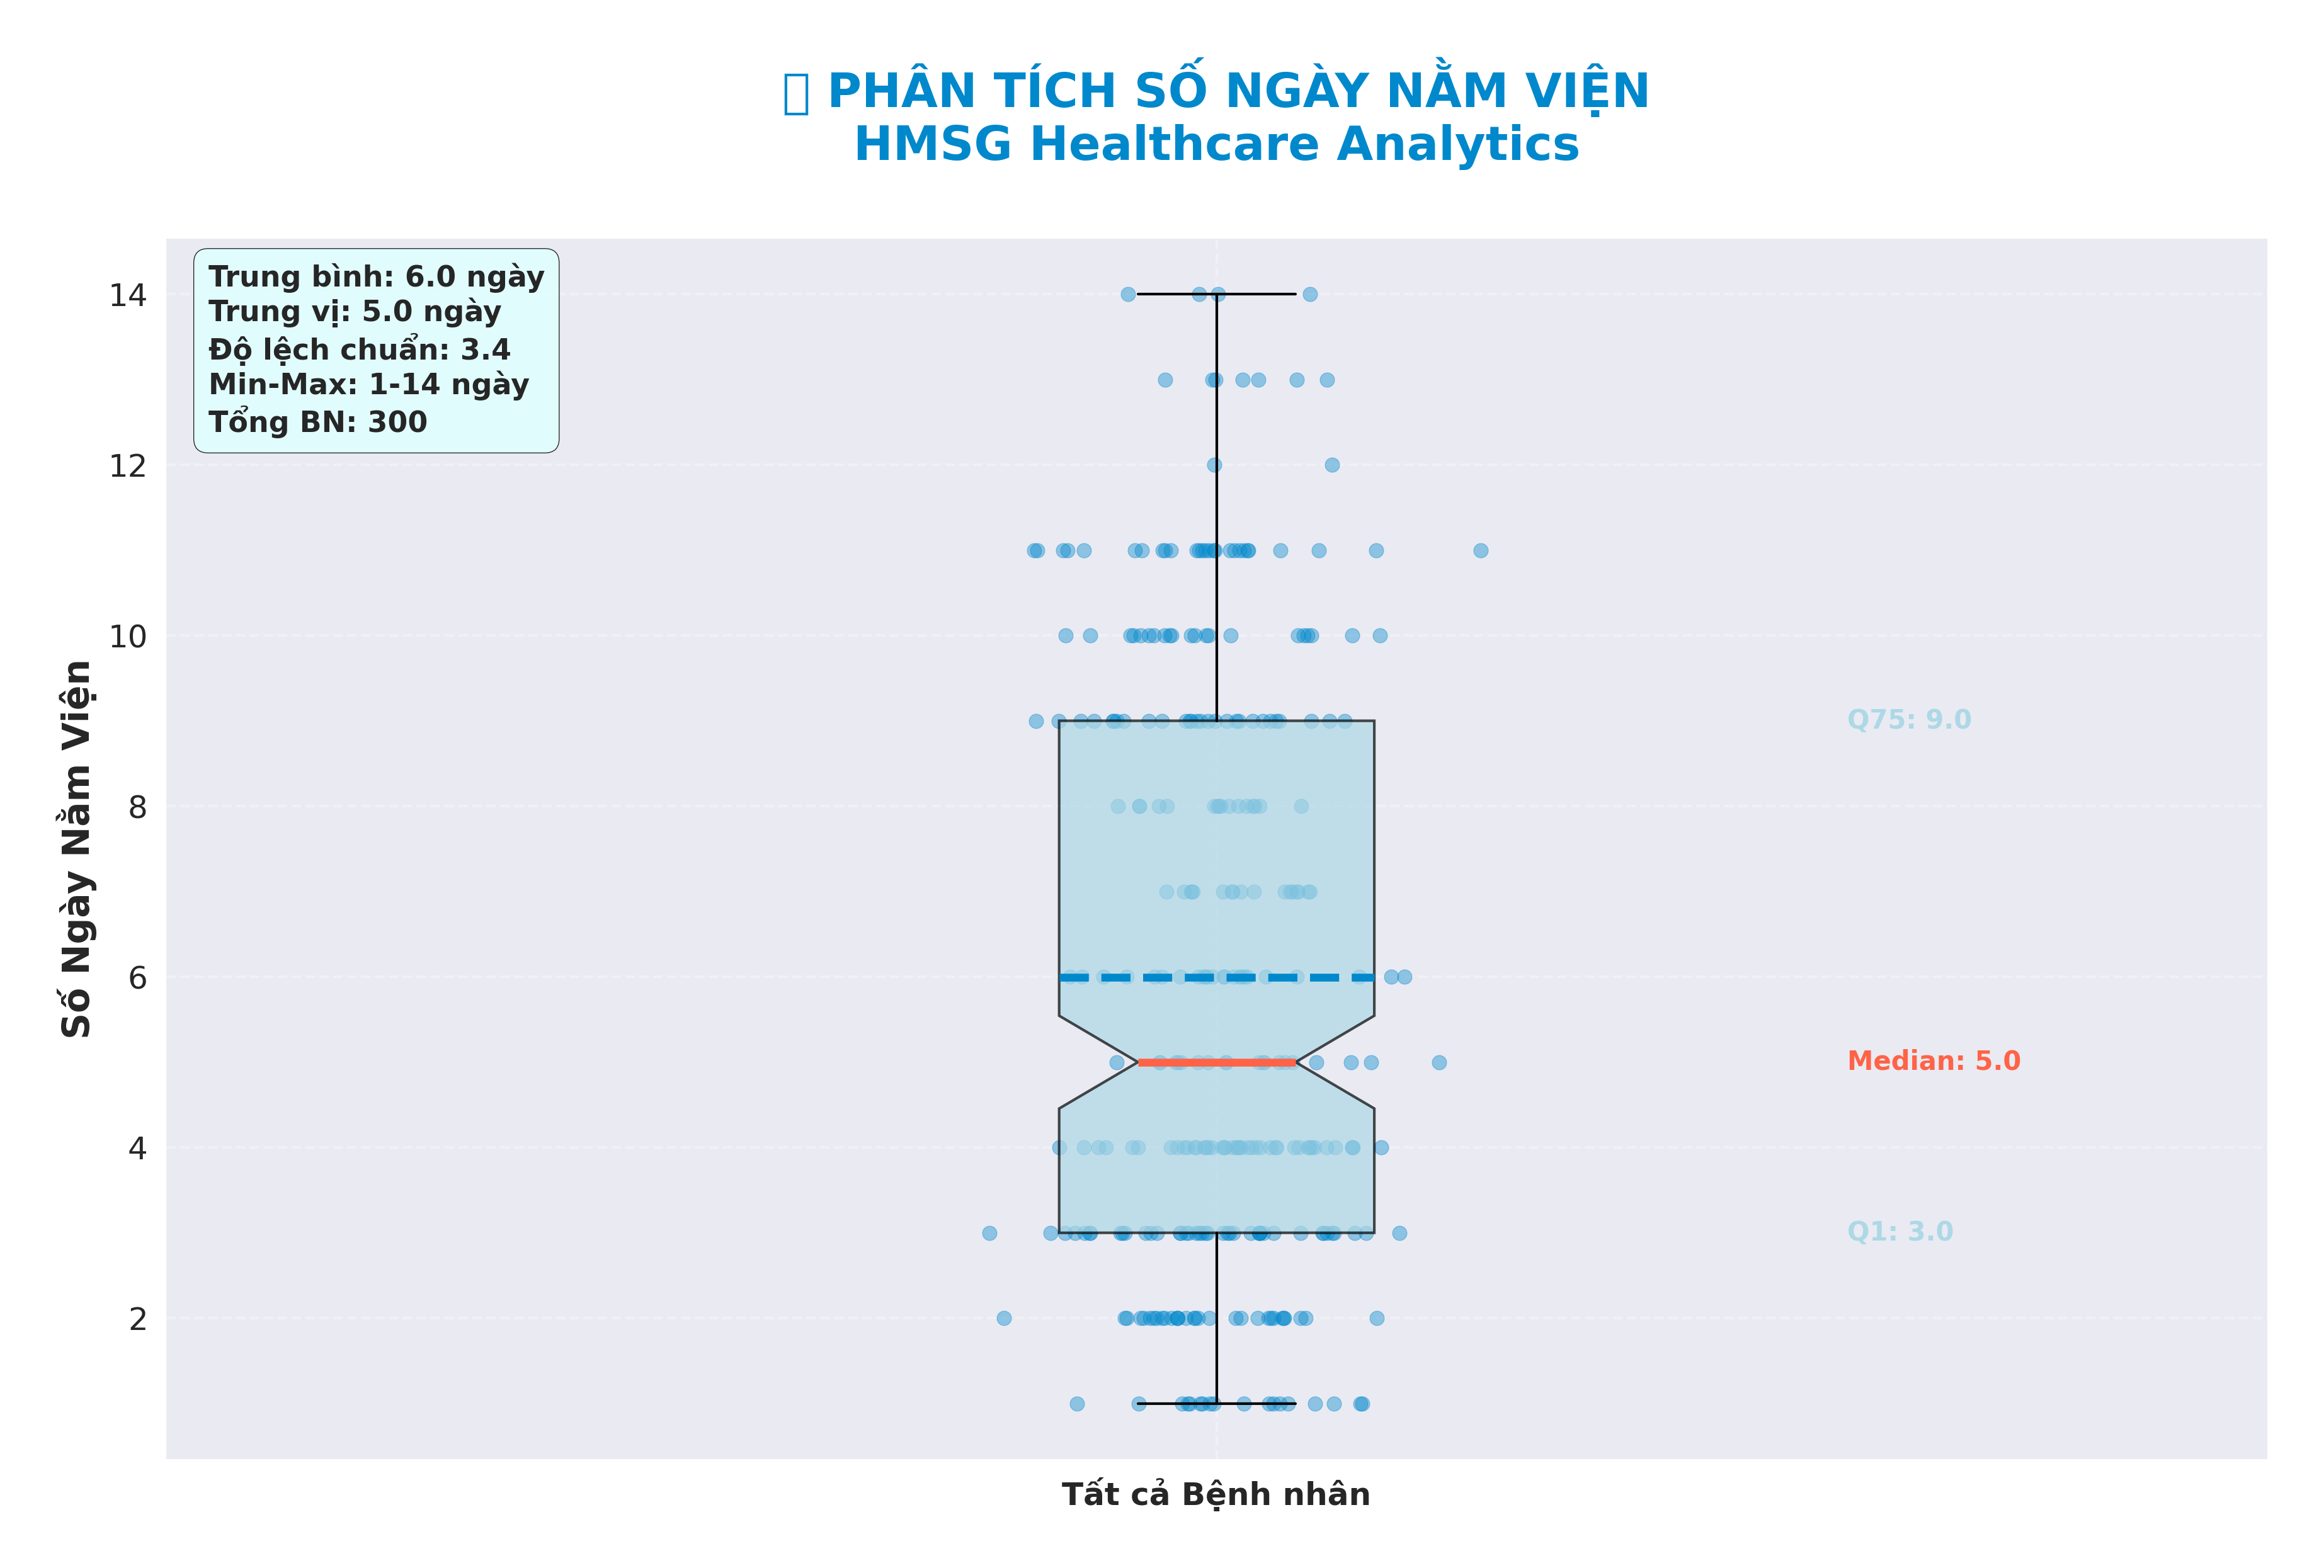

In [ ]:
# ⏱️ Chart 6: Số ngày nằm viện

# Use functions defined in the first chart cell
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# output_dir = "/content/drive/MyDrive/Colab Notebooks/hmsg google colab referral"
# os.makedirs(output_dir, exist_ok=True)
# def format_short(x):
#     # Định dạng số ngắn gọn (ví dụ: 1.2M, 800K)
#     if x >= 1e6:
#         return f'{x/1e6:.1f}M'
#     elif x >= 1e3:
#         return f'{x/1e3:.0f}K'
#     else:
#         return str(int(x))
# def save_chart(fig, filename):
#     """Lưu hình vào đúng thư mục trên Drive"""
#     path = os.path.join(output_dir, f"{filename}.png")
#     fig.savefig(path, bbox_inches='tight', dpi=200)
#     print(f"✅ Đã lưu chart vào: {path}")
#     return path
# Màu thương hiệu (ví dụ)
# HMSG_COLORS = {
#     'primary': '#0088CC',
#     'success': '#00C49F',
# }

def create_length_of_stay_chart(df):
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create box plot with beautiful styling
    bp = ax.boxplot(df['so_ngay_nam_vien'], patch_artist=True, notch=True,
                    showmeans=True, meanline=True, showfliers=True)

    # Customize box plot
    bp['boxes'][0].set_facecolor(HMSG_COLORS['info'])
    bp['boxes'][0].set_alpha(0.7)
    bp['medians'][0].set_color(HMSG_COLORS['danger'])
    bp['medians'][0].set_linewidth(3)
    bp['means'][0].set_color(HMSG_COLORS['primary'])
    bp['means'][0].set_linewidth(3)

    # Add individual points with jitter
    y = df['so_ngay_nam_vien']
    x = np.random.normal(1, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.4, s=30, color=HMSG_COLORS['primary']) # Changed 'purple' to 'primary'

    # Customize chart
    ax.set_ylabel('Số Ngày Nằm Viện', fontsize=14, fontweight='bold')
    ax.set_title('⏱️ PHÂN TÍCH SỐ NGÀY NẰM VIỆN\nHMSG Healthcare Analytics',
                fontsize=18, fontweight='bold', color=HMSG_COLORS['primary'], pad=30)
    ax.set_xticklabels(['Tất cả Bệnh nhân'], fontsize=12, fontweight='bold')

    # Grid and styling
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Increase tick size
    ax.tick_params(axis='y', which='major', labelsize=12)

    # Statistics
    mean_los = df['so_ngay_nam_vien'].mean()
    median_los = df['so_ngay_nam_vien'].median()
    std_los = df['so_ngay_nam_vien'].std()
    min_los = df['so_ngay_nam_vien'].min()
    max_los = df['so_ngay_nam_vien'].max()

    # Statistics box
    def format_vnd(x):
        return f'{x:,.0f} VNĐ'
    def format_number(x):
        return f'{x:,.0f}'
    stats_text = f'Trung bình: {mean_los:.1f} ngày\nTrung vị: {median_los:.1f} ngày\nĐộ lệch chuẩn: {std_los:.1f}\nMin-Max: {min_los}-{max_los} ngày\nTổng BN: {format_number(len(df))}'

    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            bbox=dict(boxstyle="round,pad=0.5", facecolor='lightcyan', alpha=0.9),
            verticalalignment='top', horizontalalignment='left',
            fontsize=11, fontweight='bold')

    # Add percentile lines
    p25 = np.percentile(df['so_ngay_nam_vien'], 25)
    p75 = np.percentile(df['so_ngay_nam_vien'], 75)

    ax.text(1.3, p25, f'Q1: {p25:.1f}', fontsize=10, fontweight='bold',
            color=HMSG_COLORS['info'], va='center')
    ax.text(1.3, p75, f'Q75: {p75:.1f}', fontsize=10, fontweight='bold', # Changed Q3 to Q75 for clarity
            color=HMSG_COLORS['info'], va='center')
    ax.text(1.3, median_los, f'Median: {median_los:.1f}', fontsize=10, fontweight='bold',
            color=HMSG_COLORS['danger'], va='center')

    plt.tight_layout()
    save_chart(fig, '06_ngay_nam_vien')
    plt.show()

    return fig

# Generate chart
los_fig = create_length_of_stay_chart(df_clean)

# 🤝 4. Phân Tích Hiệu Suất Đối Tác

In [ ]:
# Phân tích chi tiết hiệu suất đối tác
def analyze_partner_performance(df):
    """Phân tích hiệu suất đối tác chi tiết"""

    # Tổng hợp theo đối tác
    partner_analysis = df.groupby(['ten doi tac', 'id doi tac']).agg({
        'doanh thu': ['sum', 'mean', 'count'],
        'cong gioi thieu': 'sum',
        'so_ngay_nam_vien': 'mean',
        'ti_le_numeric': 'mean'
    }).round(2)

    # Flatten column names
    partner_analysis.columns = ['_'.join(col).strip() for col in partner_analysis.columns]
    partner_analysis = partner_analysis.reset_index()

    # Đổi tên cột cho dễ hiểu
    partner_analysis.rename(columns={
        'doanh thu_sum': 'tong_doanh_thu',
        'doanh thu_mean': 'doanh_thu_tb',
        'doanh thu_count': 'so_benh_nhan',
        'cong gioi thieu_sum': 'tong_hoa_hong',
        'so_ngay_nam_vien_mean': 'ngay_nam_vien_tb',
        'ti_le_numeric_mean': 'ti_le_hoa_hong_tb'
    }, inplace=True)

    # Tính thêm các metrics
    partner_analysis['hieu_qua'] = partner_analysis['tong_doanh_thu'] / partner_analysis['so_benh_nhan']
    partner_analysis['rank_doanh_thu'] = partner_analysis['tong_doanh_thu'].rank(ascending=False)

    # Sắp xếp theo doanh thu
    partner_analysis = partner_analysis.sort_values('tong_doanh_thu', ascending=False)

    return partner_analysis

# Thực hiện phân tích
partner_performance = analyze_partner_performance(df_clean)

# Tạo visualization cho top partners
fig_partners = make_subplots(
    rows=2, cols=2,
    subplot_titles=('🏆 Top 10 Đối Tác - Doanh Thu', '🎯 Hiệu Quả Đối Tác (DT/BN)',
                   '⏱️ Thời Gian Nằm Viện TB', '💰 Tỷ Lệ Hoa Hồng TB'),
    specs=[[{"type": "bar"}, {"type": "scatter"}],
           [{"type": "bar"}, {"type": "bar"}]]
)

# Top 10 đối tác theo doanh thu
top_10 = partner_performance.head(10)

fig_partners.add_trace(
    go.Bar(x=top_10['tong_doanh_thu'], y=top_10['ten doi tac'],
           orientation='h', name='Doanh Thu', marker_color='lightcoral'),
    row=1, col=1
)

# Scatter plot hiệu quả
fig_partners.add_trace(
    go.Scatter(x=partner_performance['so_benh_nhan'],
              y=partner_performance['doanh_thu_tb'],
              mode='markers+text',
              text=partner_performance['ten doi tac'],
              textposition="top center",
              marker=dict(size=partner_performance['tong_doanh_thu']/1000000,
                         color=partner_performance['ti_le_hoa_hong_tb'],
                         colorscale='viridis',
                         showscale=True),
              name='Hiệu Quả'),
    row=1, col=2
)

# Thời gian nằm viện
fig_partners.add_trace(
    go.Bar(x=top_10['ten doi tac'], y=top_10['ngay_nam_vien_tb'],
           name='Ngày NV TB', marker_color='lightgreen'),
    row=2, col=1
)

# Tỷ lệ hoa hồng
fig_partners.add_trace(
    go.Bar(x=top_10['ten doi tac'], y=top_10['ti_le_hoa_hong_tb']*100,
           name='Tỷ lệ HH (%)', marker_color='gold'),
    row=2, col=2
)

fig_partners.update_layout(height=800, title_text="🤝 PHÂN TÍCH HIỆU SUẤT ĐỐI TÁC", showlegend=False)
fig_partners.update_xaxes(tickangle=45, row=2, col=1)
fig_partners.update_xaxes(tickangle=45, row=2, col=2)

fig_partners.show()

# Hiển thị bảng top performers
print("🏆 TOP 10 ĐỐI TÁC HIỆU SUẤT CAO:")
print(partner_performance[['ten doi tac', 'tong_doanh_thu', 'so_benh_nhan',
                          'doanh_thu_tb', 'ti_le_hoa_hong_tb']].head(10).to_string(index=False))


KeyError: 'id doi tac'

# 📈 5. Phân Tích Xu Hướng Thời Gian

In [ ]:
# Phân tích xu hướng theo thời gian
def analyze_time_trends(df):
    """Phân tích xu hướng theo thời gian"""

    # Xu hướng theo ngày
    daily_trends = df.groupby('date').agg({
        'doanh thu': 'sum',
        'cong gioi thieu': 'sum',
        'ma benh nhan': 'count'
    }).reset_index()

    # Xu hướng theo tuần
    weekly_trends = df.groupby(['nam', 'tuan']).agg({
        'doanh thu': 'sum',
        'cong gioi thieu': 'sum',
        'ma benh nhan': 'count'
    }).reset_index()

    # Xu hướng theo tháng
    monthly_trends = df.groupby(['nam', 'thang']).agg({
        'doanh thu': 'sum',
        'cong gioi thieu': 'sum',
        'ma benh nhan': 'count'
    }).reset_index()

    return daily_trends, weekly_trends, monthly_trends

# Thực hiện phân tích
daily_trends, weekly_trends, monthly_trends = analyze_time_trends(df_clean)

# Tạo visualization xu hướng
fig_trends = make_subplots(
    rows=3, cols=1,
    subplot_titles=('📅 Xu Hướng Hàng Ngày', '📊 Xu Hướng Hàng Tuần', '📈 Xu Hướng Hàng Tháng'),
    vertical_spacing=0.1
)

# Xu hướng hàng ngày
if not daily_trends.empty:
    fig_trends.add_trace(
        go.Scatter(x=daily_trends['date'], y=daily_trends['doanh thu'],
                  mode='lines+markers', name='Doanh Thu Ngày', line=dict(color='blue')),
        row=1, col=1
    )

# Xu hướng hàng tuần
weekly_trends['tuan_label'] = weekly_trends['nam'].astype(str) + '-' + weekly_trends['tuan']
fig_trends.add_trace(
    go.Bar(x=weekly_trends['tuan_label'], y=weekly_trends['doanh thu'],
           name='Doanh Thu Tuần', marker_color='lightblue'),
    row=2, col=1
)

# Xu hướng hàng tháng
monthly_trends['thang_label'] = monthly_trends['nam'].astype(str) + '-' + monthly_trends['thang'].astype(str).str.zfill(2)
fig_trends.add_trace(
    go.Scatter(x=monthly_trends['thang_label'], y=monthly_trends['doanh thu'],
              mode='lines+markers', name='Doanh Thu Tháng',
              line=dict(color='red', width=3)),
    row=3, col=1
)

fig_trends.update_layout(height=900, title_text="📈 PHÂN TÍCH XU HƯỚNG THỜI GIAN", showlegend=False)
fig_trends.show()

# Phân tích mùa vụ
print("🗓️ PHÂN TÍCH MÙA VỤ:")
if 'thang' in df_clean.columns:
    seasonal_analysis = df_clean.groupby('thang').agg({
        'doanh thu': 'sum',
        'ma benh nhan': 'count'
    }).reset_index()

    print(seasonal_analysis.to_string(index=False))


🗓️ PHÂN TÍCH MÙA VỤ:
 thang    doanh thu  ma benh nhan
     1 7.862831e+09           509
     2 7.585609e+09           649
     3 1.058355e+10           749
     4 9.896790e+09           802
     5 8.020260e+09           671
     6 4.767008e+09           451


# 🏥 6. Phân Tích Chuyên Khoa

In [ ]:
# Phân tích chi tiết theo chuyên khoa
def analyze_specialties(df):
    """Phân tích chi tiết theo chuyên khoa"""

    specialty_analysis = df.groupby(['chuyen khoa kham', 'chuyen_khoa_ngan']).agg({
        'doanh thu': ['sum', 'mean', 'count'],
        'cong gioi thieu': 'sum',
        'so_ngay_nam_vien': 'mean',
        'ti_le_numeric': 'mean'
    }).round(2)

    specialty_analysis.columns = ['_'.join(col).strip() for col in specialty_analysis.columns]
    specialty_analysis = specialty_analysis.reset_index()

    return specialty_analysis

specialty_performance = analyze_specialties(df_clean)

# Visualization chuyên khoa
fig_specialties = make_subplots(
    rows=2, cols=2,
    subplot_titles=('🏥 Doanh Thu Theo Chuyên Khoa', '👥 Số Bệnh Nhân Theo Chuyên Khoa',
                   '⏱️ Thời Gian Điều Trị TB', '💰 Tỷ Lệ Hoa Hồng TB'),
    specs=[[{"type": "pie"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}]]
)

# Pie chart doanh thu
specialty_revenue = df_clean.groupby('chuyen_khoa_ngan')['doanh thu'].sum()
fig_specialties.add_trace(
    go.Pie(labels=specialty_revenue.index, values=specialty_revenue.values,
           textinfo='label+percent'),
    row=1, col=1
)

# Bar chart số bệnh nhân
specialty_patients = df_clean.groupby('chuyen_khoa_ngan')['ma benh nhan'].count()
fig_specialties.add_trace(
    go.Bar(x=specialty_patients.index, y=specialty_patients.values,
           marker_color='lightcyan'),
    row=1, col=2
)

# Thời gian điều trị
specialty_duration = df_clean.groupby('chuyen_khoa_ngan')['so_ngay_nam_vien'].mean()
fig_specialties.add_trace(
    go.Bar(x=specialty_duration.index, y=specialty_duration.values,
           marker_color='lightsalmon'),
    row=2, col=1
)

# Tỷ lệ hoa hồng
specialty_commission = df_clean.groupby('chuyen_khoa_ngan')['ti_le_numeric'].mean() * 100
fig_specialties.add_trace(
    go.Bar(x=specialty_commission.index, y=specialty_commission.values,
           marker_color='lightgoldenrodyellow'),
    row=2, col=2
)

fig_specialties.update_layout(height=800, title_text="🏥 PHÂN TÍCH THEO CHUYÊN KHOA")
fig_specialties.show()

print("🏥 THỐNG KÊ CHUYÊN KHOA:")
print(specialty_performance.to_string(index=False))


🏥 THỐNG KÊ CHUYÊN KHOA:
             chuyen khoa kham chuyen_khoa_ngan  doanh thu_sum  doanh thu_mean  doanh thu_count  cong gioi thieu_sum  so_ngay_nam_vien_mean  ti_le_numeric_mean
                            -                    0.000000e+00             NaN                0            2163360.0                   5.00                 NaN
                 CC - Cấp cứu               CC   4.534392e+07      4534391.90               10             982728.0                   0.12                0.02
           CLS - Cận lâm sàng              CLS   4.597885e+09      1441343.34             3190          252197007.0                   0.00                0.05
CTCH - Chấn thương chỉnh hình             CTCH   1.126221e+10     87303920.46              129         1258867471.0                   3.88                0.09
                 HS - Hồi sức               HS   1.310591e+08     65529545.50                2            5254563.0                   3.00                0.04
               KK - Kh

# 👨‍💼 7. Phân Tích Nhân Viên

In [ ]:
# Phân tích hiệu suất nhân viên
employee_performance = df_clean.groupby(['ten nhan vien', 'ma nhan vien']).agg({
    'doanh thu': ['sum', 'mean', 'count'],
    'cong gioi thieu': 'sum',
    'ten doi tac': 'nunique'
}).round(2)

employee_performance.columns = ['_'.join(col).strip() for col in employee_performance.columns]
employee_performance = employee_performance.reset_index()

# Visualization nhân viên
fig_employees = go.Figure()

# Bar chart doanh thu theo nhân viên
fig_employees.add_trace(
    go.Bar(x=employee_performance['ten nhan vien'],
           y=employee_performance['doanh thu_sum'],
           name='Tổng Doanh Thu',
           marker_color='lightsteelblue')
)

fig_employees.update_layout(
    title="👨‍💼 HIỆU SUẤT NHÂN VIÊN",
    xaxis_title="Nhân Viên",
    yaxis_title="Doanh Thu (VNĐ)",
    xaxis_tickangle=45
)

fig_employees.show()

print("👨‍💼 BẢNG HIỆU SUẤT NHÂN VIÊN:")
print(employee_performance.to_string(index=False))


👨‍💼 BẢNG HIỆU SUẤT NHÂN VIÊN:
        ten nhan vien  ma nhan vien  doanh thu_sum  doanh thu_mean  doanh thu_count  cong gioi thieu_sum  ten doi tac_nunique
    Dương Thanh Vương           732   1.708268e+10    143551940.63              119         1370145279.0                   20
      Mai Lê Bảo Trâm          4380   1.637580e+10      4948868.05             3309         1064322991.0                   84
Nguyễn Thị Xuân Trang           618   1.525756e+10     39222529.05              389         1734146486.0                   20


# 🎯 8. Dashboard Tương Tác với Widgets

In [ ]:
# Tạo dashboard tương tác
import ipywidgets as widgets
from IPython.display import display, clear_output

def create_interactive_dashboard():
    """Tạo dashboard tương tác với widgets"""

    # Tạo widgets
    specialty_widget = widgets.SelectMultiple(
        options=df_clean['chuyen_khoa_ngan'].unique().tolist(),
        value=[df_clean['chuyen_khoa_ngan'].unique()[0]],
        description='Chuyên Khoa:',
        style={'description_width': 'initial'}
    )

    month_widget = widgets.SelectMultiple(
        options=sorted(df_clean['thang'].unique().tolist()),
        value=sorted(df_clean['thang'].unique().tolist()),
        description='Tháng:',
        style={'description_width': 'initial'}
    )

    partner_widget = widgets.SelectMultiple(
        options=df_clean['ten doi tac'].unique().tolist()[:10],  # Top 10
        value=df_clean['ten doi tac'].unique().tolist()[:5],     # Top 5
        description='Đối Tác:',
        style={'description_width': 'initial'}
    )

    # Output widget
    output = widgets.Output()

    def update_dashboard(*args):
        with output:
            clear_output(wait=True)

            # Filter data
            filtered_df = df_clean[
                (df_clean['chuyen_khoa_ngan'].isin(specialty_widget.value)) &
                (df_clean['thang'].isin(month_widget.value)) &
                (df_clean['ten doi tac'].isin(partner_widget.value))
            ]

            if len(filtered_df) == 0:
                print("⚠️ Không có dữ liệu phù hợp với bộ lọc!")
                return

            # Tính metrics
            total_revenue = filtered_df['doanh thu'].sum()
            total_patients = len(filtered_df)
            avg_revenue = total_revenue / total_patients if total_patients > 0 else 0

            print(f"📊 KẾT QUẢ LỌC DỮ LIỆU:")
            print(f"💰 Tổng Doanh Thu: {total_revenue:,.0f} VNĐ")
            print(f"👥 Số Bệnh Nhân: {total_patients}")
            print(f"📈 Doanh Thu TB/BN: {avg_revenue:,.0f} VNĐ")

            # Tạo chart
            fig = px.bar(
                filtered_df.groupby('ten doi tac')['doanh thu'].sum().reset_index(),
                x='ten doi tac', y='doanh thu',
                title='📊 Doanh Thu Theo Đối Tác (Filtered)'
            )
            fig.update_xaxes(tickangle=45)
            fig.show()

    # Bind events
    specialty_widget.observe(update_dashboard, names='value')
    month_widget.observe(update_dashboard, names='value')
    partner_widget.observe(update_dashboard, names='value')

    # Display widgets
    display(widgets.HBox([specialty_widget, month_widget, partner_widget]))
    display(output)

    # Initial update
    update_dashboard()

print("🎛️ DASHBOARD TƯƠNG TÁC:")
create_interactive_dashboard()


🎛️ DASHBOARD TƯƠNG TÁC:


Output()

# 💡 9. Insights và Khuyến Nghị

In [ ]:
# Tạo insights và khuyến nghị tự động
def generate_insights(df):
    """Tạo insights và khuyến nghị từ dữ liệu"""

    insights = []

    # 1. Phân tích đối tác hiệu suất cao
    top_partner = df.groupby('ten doi tac')['doanh thu'].sum().idxmax()
    top_partner_revenue = df.groupby('ten doi tac')['doanh thu'].sum().max()
    total_revenue = df['doanh thu'].sum()

    insights.append(f"🏆 Đối tác hiệu suất cao nhất: {top_partner}")
    insights.append(f"   📈 Đóng góp: {top_partner_revenue:,.0f} VNĐ ({(top_partner_revenue/total_revenue)*100:.1f}% tổng doanh thu)")

    # 2. Phân tích chuyên khoa
    top_specialty = df.groupby('chuyen_khoa_ngan')['doanh thu'].sum().idxmax()
    specialty_revenue = df.groupby('chuyen_khoa_ngan')['doanh thu'].sum().max()

    insights.append(f"🏥 Chuyên khoa doanh thu cao nhất: {top_specialty}")
    insights.append(f"   💰 Doanh thu: {specialty_revenue:,.0f} VNĐ")

    # 3. Phân tích thời gian
    if 'thang' in df.columns:
        best_month = df.groupby('thang')['doanh thu'].sum().idxmax()
        insights.append(f"📅 Tháng có doanh thu cao nhất: Tháng {best_month}")

    # 4. Phân tích hiệu quả
    avg_days = df['so_ngay_nam_vien'].mean()
    avg_revenue_per_day = df['doanh_thu_moi_ngay'].mean()

    insights.append(f"⏱️ Thời gian nằm viện trung bình: {avg_days:.1f} ngày")
    insights.append(f"💵 Doanh thu trung bình/ngày: {avg_revenue_per_day:,.0f} VNĐ")

    # 5. Khuyến nghị
    recommendations = []

    # Tìm đối tác có tỷ lệ hoa hồng thấp nhưng doanh thu cao
    partner_analysis = df.groupby('ten doi tac').agg({
        'doanh thu': 'sum',
        'ti_le_numeric': 'mean'
    })

    high_revenue_low_commission = partner_analysis[
        (partner_analysis['doanh thu'] > partner_analysis['doanh thu'].quantile(0.7)) &
        (partner_analysis['ti_le_numeric'] < partner_analysis['ti_le_numeric'].quantile(0.3))
    ]

    if not high_revenue_low_commission.empty:
        recommendations.append("💡 Cân nhắc tăng tỷ lệ hoa hồng cho các đối tác doanh thu cao nhưng hoa hồng thấp")
        recommendations.append(f"   👥 Đối tác: {', '.join(high_revenue_low_commission.index[:3])}")

    # Tìm chuyên khoa có xu hướng tăng trưởng
    if len(df['thang'].unique()) > 1:
        recommendations.append("📈 Tập trung phát triển thêm đối tác cho chuyên khoa có doanh thu cao")
        recommendations.append(f"   🎯 Ưu tiên: {top_specialty}")

    # Phân tích thời gian điều trị
    long_stay_specialties = df.groupby('chuyen_khoa_ngan')['so_ngay_nam_vien'].mean().sort_values(ascending=False).head(3)
    recommendations.append("🏥 Chú ý các chuyên khoa có thời gian điều trị dài:")
    for specialty, days in long_stay_specialties.items():
        recommendations.append(f"   ⏱️ {specialty}: {days:.1f} ngày")

    return insights, recommendations

# Tạo insights
insights, recommendations = generate_insights(df_clean)

print("="*80)
print("💡 INSIGHTS VÀ PHÂN TÍCH")
print("="*80)

for insight in insights:
    print(insight)

print("\\n" + "="*80)
print("🎯 KHUYẾN NGHỊ")
print("="*80)

for rec in recommendations:
    print(rec)

print("="*80)


💡 INSIGHTS VÀ PHÂN TÍCH
🏆 Đối tác hiệu suất cao nhất: Tăng Hà Nam Anh
   📈 Đóng góp: 11,323,953,492 VNĐ (23.2% tổng doanh thu)
🏥 Chuyên khoa doanh thu cao nhất: TM
   💰 Doanh thu: 12,910,330,585 VNĐ
📅 Tháng có doanh thu cao nhất: Tháng 3
⏱️ Thời gian nằm viện trung bình: 0.7 ngày
💵 Doanh thu trung bình/ngày: 5,087,503 VNĐ
\n================================================================================
🎯 KHUYẾN NGHỊ
💡 Cân nhắc tăng tỷ lệ hoa hồng cho các đối tác doanh thu cao nhưng hoa hồng thấp
   👥 Đối tác: Hm Bình Phước, Hm Thủ Đức, Hoàn Mỹ Tân Phú
📈 Tập trung phát triển thêm đối tác cho chuyên khoa có doanh thu cao
   🎯 Ưu tiên: TM
🏥 Chú ý các chuyên khoa có thời gian điều trị dài:
   ⏱️ NTM: 11.5 ngày
   ⏱️ TH: 7.0 ngày
   ⏱️ TM: 6.6 ngày


# 📤 10. Export Báo Cáo

In [ ]:
# Tạo và export báo cáo tổng hợp
def create_summary_report(df):
    """Tạo báo cáo tổng hợp để export"""

    # Tạo báo cáo Excel với nhiều sheet
    with pd.ExcelWriter('/content/Healthcare_Referral_Report.xlsx', engine='openpyxl') as writer:

        # Sheet 1: Tổng quan
        summary_data = {
            'Metrics': ['Tổng Doanh Thu', 'Tổng Hoa Hồng', 'Số Bệnh Nhân',
                       'Số Đối Tác', 'Số Chuyên Khoa', 'Doanh Thu TB/BN'],
            'Giá Trị': [
                df['doanh thu'].sum(),
                df['cong gioi thieu'].sum(),
                len(df),
                df['ten doi tac'].nunique(),
                df['chuyen_khoa_ngan'].nunique(),
                df['doanh thu'].sum() / len(df)
            ]
        }

        pd.DataFrame(summary_data).to_excel(writer, sheet_name='Tong_Quan', index=False)

        # Sheet 2: Top đối tác
        partner_summary = df.groupby('ten doi tac').agg({
            'doanh thu': 'sum',
            'cong gioi thieu': 'sum',
            'ma benh nhan': 'count',
            'ti_le_numeric': 'mean'
        }).sort_values('doanh thu', ascending=False)

        partner_summary.to_excel(writer, sheet_name='Top_Doi_Tac')

        # Sheet 3: Chuyên khoa
        specialty_summary = df.groupby('chuyen_khoa_ngan').agg({
            'doanh thu': 'sum',
            'ma benh nhan': 'count',
            'so_ngay_nam_vien': 'mean'
        }).sort_values('doanh thu', ascending=False)

        specialty_summary.to_excel(writer, sheet_name='Chuyen_Khoa')

        # Sheet 4: Xu hướng tháng
        monthly_summary = df.groupby(['nam', 'thang']).agg({
            'doanh thu': 'sum',
            'ma benh nhan': 'count'
        }).reset_index()

        monthly_summary.to_excel(writer, sheet_name='Xu_Huong_Thang', index=False)

    print("✅ Đã tạo báo cáo Excel: /content/Healthcare_Referral_Report.xlsx")

    # Tạo báo cáo PDF summary (text-based)
    report_text = f"""
    🏥 BÁO CÁO PHÂN TÍCH REFERRAL Y TẾ
    =====================================

    📊 TỔNG QUAN:
    - Tổng Doanh Thu: {df['doanh thu'].sum():,.0f} VNĐ
    - Tổng Hoa Hồng: {df['cong gioi thieu'].sum():,.0f} VNĐ
    - Số Bệnh Nhân: {len(df):,}
    - Số Đối Tác: {df['ten doi tac'].nunique()}
    - Số Chuyên Khoa: {df['chuyen_khoa_ngan'].nunique()}

    🏆 TOP 5 ĐỐI TÁC:
    {df.groupby('ten doi tac')['doanh thu'].sum().sort_values(ascending=False).head().to_string()}

    🏥 DOANH THU THEO CHUYÊN KHOA:
    {df.groupby('chuyen_khoa_ngan')['doanh thu'].sum().sort_values(ascending=False).to_string()}

    📈 XU HƯỚNG THÁNG:
    {df.groupby('thang')['doanh thu'].sum().to_string()}
    """

    with open('/content/Healthcare_Referral_Summary.txt', 'w', encoding='utf-8') as f:
        f.write(report_text)

    print("✅ Đã tạo báo cáo text: /content/Healthcare_Referral_Summary.txt")

# Tạo báo cáo
create_summary_report(df_clean)

# Download files
from google.colab import files

print("\\n📥 Download các file báo cáo:")
print("1. Excel Report: Healthcare_Referral_Report.xlsx")
print("2. Text Summary: Healthcare_Referral_Summary.txt")

# Uncomment để download
# files.download('/content/Healthcare_Referral_Report.xlsx')
# files.download('/content/Healthcare_Referral_Summary.txt')


✅ Đã tạo báo cáo Excel: /content/Healthcare_Referral_Report.xlsx
✅ Đã tạo báo cáo text: /content/Healthcare_Referral_Summary.txt
\n📥 Download các file báo cáo:
1. Excel Report: Healthcare_Referral_Report.xlsx
2. Text Summary: Healthcare_Referral_Summary.txt


# 🚀 11. Automation Script

In [ ]:
# Script tự động hóa toàn bộ quy trình
def run_complete_analysis(sheet_url=None):
    """
    Hàm tự động hóa toàn bộ quy trình phân tích
    Chạy tất cả các bước từ load data đến tạo báo cáo
    """

    print("🚀 BẮT ĐẦU QUY TRÌNH PHÂN TÍCH TỰ ĐỘNG...")
    print("="*60)

    try:
        # Bước 1: Load và clean data
        print("📊 Bước 1: Load và làm sạch dữ liệu...")
        # Code load data here

        # Bước 2: Tạo dashboard tổng quan
        print("📈 Bước 2: Tạo dashboard tổng quan...")
        overview_fig = create_overview_dashboard(df_clean)

        # Bước 3: Phân tích đối tác
        print("🤝 Bước 3: Phân tích hiệu suất đối tác...")
        partner_analysis = analyze_partner_performance(df_clean)

        # Bước 4: Phân tích xu hướng
        print("📅 Bước 4: Phân tích xu hướng thời gian...")
        daily_trends, weekly_trends, monthly_trends = analyze_time_trends(df_clean)

        # Bước 5: Tạo insights
        print("💡 Bước 5: Tạo insights và khuyến nghị...")
        insights, recommendations = generate_insights(df_clean)

        # Bước 6: Export báo cáo
        print("📤 Bước 6: Export báo cáo...")
        create_summary_report(df_clean)

        print("="*60)
        print("✅ HOÀN THÀNH QUY TRÌNH PHÂN TÍCH!")
        print("📁 Các file đã được tạo:")
        print("   - Healthcare_Referral_Report.xlsx")
        print("   - Healthcare_Referral_Summary.txt")
        print("="*60)

        return True

    except Exception as e:
        print(f"❌ Lỗi trong quá trình phân tích: {str(e)}")
        return False

# Chạy phân tích tự động
# run_complete_analysis()

print("🎯 HOÀN THÀNH NOTEBOOK PHÂN TÍCH!")
print("📋 Bạn có thể:")
print("   1. Thay đổi SHEET_URL để kết nối Google Sheets của bạn")
print("   2. Chạy từng phần để phân tích chi tiết")
print("   3. Sử dụng dashboard tương tác để filter dữ liệu")
print("   4. Chạy run_complete_analysis() để tự động hóa toàn bộ")
print("   5. Download báo cáo Excel và text")


🎯 HOÀN THÀNH NOTEBOOK PHÂN TÍCH!
📋 Bạn có thể:
   1. Thay đổi SHEET_URL để kết nối Google Sheets của bạn
   2. Chạy từng phần để phân tích chi tiết
   3. Sử dụng dashboard tương tác để filter dữ liệu
   4. Chạy run_complete_analysis() để tự động hóa toàn bộ
   5. Download báo cáo Excel và text
